In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import DBSCAN
import random
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [3]:
# IMPORT DATA

df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)
print(df)


                   business_id                     name               address  \
0       6iYb2HFDywm3zjuRg0shjw      Oskar Blues Taproom          921 Pearl St   
1       tCbdrRPZA0oiIYSmHG3J0w  Flying Elephants at PDX   7000 NE Airport Way   
2       bvN78flM8NLprQ1a1y5dRg           The Reclaimory    4720 Hawthorne Ave   
3       oaepsyvc0J17qwi8cfrOWg              Great Clips    2566 Enterprise Rd   
4       PE9uqAjdw0E4-8mjGl3wVA        Crossfit Terminus   1046 Memorial Dr SE   
...                        ...                      ...                   ...   
160580  D2mHoIDXx9N8mS1pGoKV9Q       Eleven Oaks Realty                         
160581  bQX-kwVTyZgcdZGEPzce6Q             Webb's Honey    21777 State Rd 520   
160582  wvFZ06nmPmQ2-IVoPqVYLA    Painting with a Twist  2164 S Chickasaw Trl   
160583  GB75wPibj3IjNauaoCxyGA              Havana Cafe        910 NW 14th St   
160584  ngmLL5Y5OT-bYHKU0kKrYA              Zora Grille   1370 E Altamonte Dr   

                     city s

In [4]:
# CLEAN DATA

n = 10
print(df['state'].value_counts()[:n].index.tolist())


df_filtered = df[(df['state']=='MA')]
df_cluster = df_filtered.filter(items=['business_id','latitude','longitude','categories', 'review_count', 'stars'])
df_filtered = df_filtered.filter(items=['business_id','name','address','city','state','stars','review_count','is_open','attributes','categories'])

print(df_filtered)
print(df_filtered.shape[0])




['MA', 'OR', 'TX', 'FL', 'GA', 'BC', 'OH', 'CO', 'WA', 'CA']
                   business_id                                 name  \
11      hCABMnKtwo4Y9alQDxh2kw         Star Kreations Salon and Spa   
12      HPA_qyMEddpAEtFof02ixg                  Mr G's Pizza & Subs   
18      6fT0lYr_UgWSCZs_w1PBTQ                        Salter School   
26      hcRxdDg7DYryCxCoI8ySQA                    Longwood Galleria   
29      jGennaZUr2MsJyRhijNBfA                      Legal Sea Foods   
...                        ...                                  ...   
160556  87f7kR7nTz8WHnmtLM_S6w                                 O Ya   
160563  yQL8SrSETbbCI1U5esVJQw                  Ciao! Pizza & Pasta   
160568  hX-wc8LoHWSWjBwZ84ANcg          Chestnut Green Dental Group   
160569  _-nynGfhsMVVWWbAZ6YhTw                        The Jury Room   
160579  d6iEdtgLKelWKtb-2UmE2A  Master Finish Mobile Auto Detailing   

                       address     city state  stars  review_count  is_open  \
11     

## Cluster based on location

In [5]:
df_cluster

business_id   latitude  longitude  \
11      hCABMnKtwo4Y9alQDxh2kw  42.534248 -70.990948   
12      HPA_qyMEddpAEtFof02ixg  42.541155 -70.973438   
18      6fT0lYr_UgWSCZs_w1PBTQ  42.427889 -71.073475   
26      hcRxdDg7DYryCxCoI8ySQA  42.338544 -71.106842   
29      jGennaZUr2MsJyRhijNBfA  42.363442 -71.025781   
...                        ...        ...        ...   
160556  87f7kR7nTz8WHnmtLM_S6w  42.351408 -71.056867   
160563  yQL8SrSETbbCI1U5esVJQw  42.389221 -71.040882   
160568  hX-wc8LoHWSWjBwZ84ANcg  42.550054 -70.944788   
160569  _-nynGfhsMVVWWbAZ6YhTw  42.249118 -71.001071   
160579  d6iEdtgLKelWKtb-2UmE2A  42.282399 -71.225169   

                                               categories  review_count  stars  
11      Wigs, Hair Extensions, Hair Salons, Blow Dry/O...             8    4.0  
12                               Food, Pizza, Restaurants            39    4.0  
18      Specialty Schools, Massage Schools, Middle Sch...             5    2.0  
26                Restaurants, Shopping, Shopping Centers            24    2.5  
29      Sandwiches, Food, Restaurants, Breakfast & Bru...           856    3.5  
...                                                   ...           ...    ...  
160556                  Japanese, Sushi Bars, Restaurants           737    4.5  
160563                        Restaurants, Pizza, Italian           733    5.0  
160568      Health & Medical, Dentists, General Dentistry             6    3.0  
160569             Restaurants, American (New), Nightlife            30    3.0  
160579                         Automotive, Auto Detailing            11    1.0  

[36012 rows x 6 columns]

In [6]:
df_location = df_cluster.filter(items= ['latitude','longitude'])
df_location

latitude  longitude
11      42.534248 -70.990948
12      42.541155 -70.973438
18      42.427889 -71.073475
26      42.338544 -71.106842
29      42.363442 -71.025781
...           ...        ...
160556  42.351408 -71.056867
160563  42.389221 -71.040882
160568  42.550054 -70.944788
160569  42.249118 -71.001071
160579  42.282399 -71.225169

[36012 rows x 2 columns]

In [7]:
db = DBSCAN(eps=0.00001, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(df_location))

In [8]:
labels = db.labels_

In [9]:
labels

array([ 0,  1,  2, ..., -1, 27, -1])

In [10]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

In [11]:
-1 in labels

True

In [12]:
df_location.iloc(0)[2]['latitude']

42.427889

In [13]:
len(colors)

2131

In [14]:
labels[1]
random.shuffle(colors)

Plotting for location clusters

/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_29011/4157913855.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')


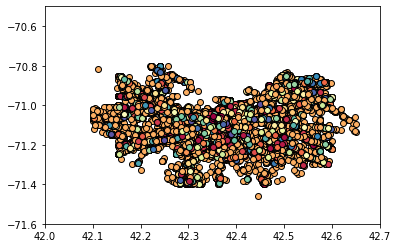

In [15]:
plt.xlim(42,42.7)
plt.ylim(-71.6,-70.5)
for i in range(0,len(labels)):
    if(labels[i] == -1):
       c = [0,0,0,1]
    c = colors[labels[i]]
    x = df_location.iloc(0)[i]['latitude']
    y = df_location.iloc(0)[i]['longitude']
    plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')

Generate list of dataframe, each containing a cluster

In [16]:
cluster_list = [None] * (len(set(labels))-1)
for i in range(0,len(labels)):
    index = labels[i]
    if index != -1:
        if cluster_list[index] == None:
            cluster_list[index] = []
            cluster_list[index].append(df_cluster.iloc(0)[i])
        else:
            cluster_list[index].append(df_cluster.iloc(0)[i])

In [17]:
for i in range(0, len(cluster_list)):
    df_new = pd.DataFrame(cluster_list[i])
    cluster_list[i] = df_new

In [18]:
t = np.array(cluster_list[0]['categories']).tolist()

In [19]:
for i in range(0,len(t)):
    text = t[i]
    t[i] = [x.strip() for x in text.split(',')]


In [20]:
unique_categories = list(set(i for j in t for i in j))
df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)

In [21]:
for i in range(0,len(t)):
    for each in t[i]:
        df_test.loc[i,each] = each
df_test.loc[0,'Wigs']
df_test.isnull().values.any()
df_test
df_test.shape

(3, 17)

In [22]:
while(df_test.isnull().values.any()==True):
    df_test.fillna(str(random.random() * 10000),inplace=True,limit=1)

In [31]:
km = KModes(n_clusters=50, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(df_test)

AssertionError: Cannot have more clusters (50) than data points (3).

In [32]:
l = [None] * len(set(clusters))
for i in range(0,len(clusters)):
    index = clusters[i]
    if index != -1:
        if l[index] == None:
            l[index] = []
            l[index].append(cluster_list[0].iloc(0)[i])
        else:
            l[index].append(cluster_list[0].iloc(0)[i])


NameError: name 'clusters' is not defined

## Clustering for each location cluster

The result is expected to be a list, with each element as a list of clusters. 

In [23]:
res = []
for i in range(0,len(cluster_list)):
    print("%d run:" %(i))
    t = np.array(cluster_list[i]['categories']).tolist()
    for j in range(0,len(t)):
        text = t[j]
        if(text == None):
            text = 'None'
        t[j] = [x.strip() for x in text.split(',')]
    unique_categories = list(set(k for j in t for k in j))
    df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)
    for j in range(0,len(t)):
        for each in t[j]:
            df_test.loc[j,each] = 1/len(t[j])
        df_test.fillna(0,inplace=True)
    km = KMeans(n_clusters=int(min(df_test.shape[0]/4+1,50)),verbose=1).fit(df_test)
    clusters = km.labels_
    l = [None] * len(set(clusters))
    for j in range(0,len(clusters)):
        index = clusters[j]
        if index != -1:
            if l[index] == None:
                l[index] = []
                l[index].append(cluster_list[i].iloc(0)[j])
            else:
                l[index].append(cluster_list[i].iloc(0)[j])
    res.append(l)

0 run:
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, ine

Initialization complete
Iteration 0, inertia 8.942210368996085
Iteration 1, inertia 5.777932377917497
Iteration 2, inertia 5.700571707723493
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.896320346320346
Iteration 1, inertia 5.467161620846686
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.706623376623376
Iteration 1, inertia 5.413725388808722
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.731255411255411
Iteration 1, inertia 5.440328757014116
Iteration 2, inertia 5.377470195148767
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.679862914862916
Iteration 1, inertia 5.546971311757026
Iteration 2, inertia 5.421373195021154
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.604926819212533
Iteration 1, inertia 5.271913029100529
Converged at iteration 1: strict converge

Iteration 1, inertia 1.5995370370370372
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2583333333333333
Iteration 1, inertia 1.5753395061728397
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.258333333333333
Iteration 1, inertia 1.6023888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.730555555555556
Iteration 1, inertia 1.6319444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.541666666666667
Iteration 1, inertia 1.452314814814815
Converged at iteration 1: strict convergence.
12 run:
Initialization complete
Iteration 0, inertia 5.917857142857143
Iteration 1, inertia 3.0630853174603176
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.292857142857143
Iteration 1, inertia 2.826638321995465
Converged at iteration 1: strict convergence.
Initializatio

Initialization complete
Iteration 0, inertia 677.4823844818948
Iteration 1, inertia 503.3998511544514
Iteration 2, inertia 479.7789466155798
Iteration 3, inertia 473.9925369025415
Iteration 4, inertia 471.4062526370287
Iteration 5, inertia 470.1598459426596
Iteration 6, inertia 469.21874344486866
Iteration 7, inertia 467.91961129176536
Iteration 8, inertia 466.07729684881446
Iteration 9, inertia 464.1175589544659
Iteration 10, inertia 463.10001824160554
Iteration 11, inertia 463.00207590948565
Iteration 12, inertia 462.9915581194079
Iteration 13, inertia 462.98929874156835
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 709.3067720338123
Iteration 1, inertia 512.4240502644834
Iteration 2, inertia 482.4998719697338
Iteration 3, inertia 472.37241481499507
Iteration 4, inertia 468.07322044545606
Iteration 5, inertia 466.51267319285813
Iteration 6, inertia 465.86812550420086
Iteration 7, inertia 465.6498302594064
Iteration 8, inertia 465.55505664

Initialization complete
Iteration 0, inertia 39.789096260881976
Iteration 1, inertia 28.288406613776182
Iteration 2, inertia 27.897954484356397
Iteration 3, inertia 27.71338134812579
Iteration 4, inertia 27.498966080017407
Iteration 5, inertia 27.402150122669404
Iteration 6, inertia 27.367733627613646
Iteration 7, inertia 27.356392268304262
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 40.90776778116063
Iteration 1, inertia 28.627484461431038
Iteration 2, inertia 28.10279216957937
Iteration 3, inertia 28.002139076344918
Iteration 4, inertia 27.958474830197996
Iteration 5, inertia 27.872534753851888
Iteration 6, inertia 27.846503420643494
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 40.70365417651132
Iteration 1, inertia 28.16481450649027
Iteration 2, inertia 27.664857617406792
Iteration 3, inertia 27.218869023018154
Iteration 4, inertia 27.054938520765848
Iteration 5, inertia 26.963077210097026
I

Initialization complete
Iteration 0, inertia 4.114739229024943
Iteration 1, inertia 2.7841252398395255
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.455873015873016
Iteration 1, inertia 2.847766439909297
Converged at iteration 1: strict convergence.
22 run:
Initialization complete
Iteration 0, inertia 19.577888839555513
Iteration 1, inertia 13.4380270390503
Iteration 2, inertia 13.125522493195074
Iteration 3, inertia 12.986793120165657
Iteration 4, inertia 12.945252653773341
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 19.637819440460135
Iteration 1, inertia 13.205965558461749
Iteration 2, inertia 12.945801375302235
Iteration 3, inertia 12.922738097683844
Iteration 4, inertia 12.90237177734458
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 19.216719306026665
Iteration 1, inertia 12.714900949711241
Iteration 2, inertia 12.675064769612568
Converged at i

Initialization complete
Iteration 0, inertia 21.627811791383223
Iteration 1, inertia 14.978295164596629
Iteration 2, inertia 14.697971947101784
Iteration 3, inertia 14.522910498672402
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 21.741192002442002
Iteration 1, inertia 14.581218866536815
Iteration 2, inertia 14.345422176588842
Iteration 3, inertia 14.242961859128526
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 21.648946595732312
Iteration 1, inertia 14.531194323995994
Iteration 2, inertia 14.12329144217041
Iteration 3, inertia 14.031672766026295
Iteration 4, inertia 14.014141068238786
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 21.214723748473745
Iteration 1, inertia 14.413540647805693
Iteration 2, inertia 14.184083690706704
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 22.840338827838828
Iteration 1, iner

Initialization complete
Iteration 0, inertia 11.958225451796881
Iteration 1, inertia 7.888675661021184
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 12.81230960397627
Iteration 1, inertia 7.905104775075014
Iteration 2, inertia 7.856310722220587
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.908297258297257
Iteration 1, inertia 7.698110335211527
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 12.178193442360106
Iteration 1, inertia 8.15258032437629
Iteration 2, inertia 8.085525508477133
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.720165945165945
Iteration 1, inertia 7.687537652879761
Iteration 2, inertia 7.654108673660261
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.735433702100368
Iteration 1, inertia 7.5267892890681996
Iteration 2, inertia 7.4971513845344

Initialization complete
Iteration 0, inertia 28.811970485422865
Iteration 1, inertia 18.81628456126487
Iteration 2, inertia 18.03416996975071
Iteration 3, inertia 17.799270953056123
Iteration 4, inertia 17.773255450072156
Iteration 5, inertia 17.713255698981495
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 28.717748362748363
Iteration 1, inertia 18.97213405869865
Iteration 2, inertia 18.533522636069517
Iteration 3, inertia 18.451807323185317
Iteration 4, inertia 18.390913067535877
Iteration 5, inertia 18.356393952572077
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 27.709887467030327
Iteration 1, inertia 18.192558154313993
Iteration 2, inertia 17.947196144059227
Iteration 3, inertia 17.886831675988013
Iteration 4, inertia 17.815835441532208
Iteration 5, inertia 17.78286882374809
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 28.773818787033075
Iteration 

Iteration 0, inertia 2.25
Iteration 1, inertia 1.0625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9166666666666665
Iteration 1, inertia 1.013888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9166666666666665
Iteration 1, inertia 1.013888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9166666666666665
Iteration 1, inertia 1.013888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.0625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.083333333333333
Iteration 1, inertia 1.0625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 1.1875
Converged at iteration 1: strict convergence.
45 run:
Initialization complete
Iteration 0, inertia 1.0333333333333

Initialization complete
Iteration 0, inertia 5.8839770723104055
Iteration 1, inertia 3.4634838750314945
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.902724867724868
Iteration 1, inertia 3.7938601190476193
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.785405643738978
Iteration 1, inertia 3.7852931048962795
Iteration 2, inertia 3.722787061532432
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.680908289241622
Iteration 1, inertia 3.7511838624338623
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.6079365079365076
Iteration 1, inertia 3.8995348174543185
Iteration 2, inertia 3.8392116157162453
Iteration 3, inertia 3.785999645930201
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 5.369003527336861
Iteration 1, inertia 3.596910077405447
Iteration 2, inertia 3.5094100774

Initialization complete
Iteration 0, inertia 22.615671867814726
Iteration 1, inertia 15.28602068358358
Iteration 2, inertia 14.898624634145293
Iteration 3, inertia 14.865423246687952
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 22.197142024642027
Iteration 1, inertia 15.19657719978058
Iteration 2, inertia 14.999631916140146
Iteration 3, inertia 14.913162206948805
Iteration 4, inertia 14.876863471698787
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 22.58724849224849
Iteration 1, inertia 15.108692772574248
Iteration 2, inertia 15.067848577380737
Iteration 3, inertia 15.044815205297347
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 22.452371517371517
Iteration 1, inertia 14.677020380493085
Iteration 2, inertia 14.55981236040339
Iteration 3, inertia 14.46728942446993
Iteration 4, inertia 14.426280240916107
Converged at iteration 4: strict convergence.
Initi

Initialization complete
Iteration 0, inertia 3.7055555555555557
Iteration 1, inertia 2.437962962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8500000000000005
Iteration 1, inertia 2.355952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.0888888888888895
Iteration 1, inertia 2.2847222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.888888888888889
Iteration 1, inertia 2.443518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.2
Iteration 1, inertia 2.3177777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.433333333333334
Iteration 1, inertia 2.469444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.116666666666667
Iteration 1, inertia 2.3803030303030304
Converged at itera

Initialization complete
Iteration 0, inertia 11.432857142857143
Iteration 1, inertia 7.342401704729512
Iteration 2, inertia 7.269487292752599
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.489909297052154
Iteration 1, inertia 7.123271784904437
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 11.96125850340136
Iteration 1, inertia 7.190526325113378
Iteration 2, inertia 6.997438271604938
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.306859410430839
Iteration 1, inertia 6.944989417989419
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 11.45778911564626
Iteration 1, inertia 7.298291453206797
Iteration 2, inertia 7.226691830435879
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.057312925170068
Iteration 1, inertia 7.119588399901479
Iteration 2, inertia 7.07022902494331

Initialization complete
Iteration 0, inertia 12.924193121693124
Iteration 1, inertia 9.018283081089125
Iteration 2, inertia 8.85095475391011
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.930976001511718
Iteration 1, inertia 9.209513497125041
Iteration 2, inertia 9.108900913721971
Iteration 3, inertia 9.05661041824137
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13.532749433106579
Iteration 1, inertia 9.18013460389447
Iteration 2, inertia 9.117679048338912
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.108895502645504
Iteration 1, inertia 9.077847190728143
Iteration 2, inertia 9.040369236583523
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.58554232804233
Iteration 1, inertia 9.07959211984676
Iteration 2, inertia 9.045091499298131
Converged at iteration 2: strict convergence.
Initialization complete
It

Initialization complete
Iteration 0, inertia 14.865066137566139
Iteration 1, inertia 9.673168674836006
Iteration 2, inertia 9.527018487024437
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 14.674391534391537
Iteration 1, inertia 9.964041005291005
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 15.06276455026455
Iteration 1, inertia 9.44228596905032
Iteration 2, inertia 9.287353835978834
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 14.748015873015872
Iteration 1, inertia 9.815586985293045
Iteration 2, inertia 9.619519841269842
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 14.507658730158731
Iteration 1, inertia 9.573972752897454
Iteration 2, inertia 9.517019111039048
Iteration 3, inertia 9.476749338624337
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14.40400793650793

Initialization complete
Iteration 0, inertia 10.126346801346802
Iteration 1, inertia 6.582907380685159
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.561592111592113
Iteration 1, inertia 6.4568299881936255
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.34155844155844
Iteration 1, inertia 6.865311676859297
Iteration 2, inertia 6.773027726242013
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.188973063973064
Iteration 1, inertia 6.434045643509929
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.483958633958634
Iteration 1, inertia 6.6997746579552135
Iteration 2, inertia 6.65978213254999
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.659299342632675
Iteration 1, inertia 6.913435636123137
Converged at iteration 1: strict convergence.
Initialization complete
Itera

Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
91 run:
Initialization complete
Iteration 0, inertia 84.4500448039638
Iteration 1, inertia 58.25779182693863
Iteration 2, inertia 56.661073878992056
Iteration 3, inertia 56.07932670882178
Iteration 4

Initialization complete
Iteration 0, inertia 16.358374874283964
Iteration 1, inertia 10.670811782699936
Iteration 2, inertia 10.577916773069806
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.52589586339586
Iteration 1, inertia 10.398508285695787
Iteration 2, inertia 10.338729622001226
Iteration 3, inertia 10.300529119029118
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 16.266156004489336
Iteration 1, inertia 10.459011573379133
Iteration 2, inertia 10.410054658036543
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.821534792368125
Iteration 1, inertia 10.820061255029508
Iteration 2, inertia 10.778212115045449
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.60092231842232
Iteration 1, inertia 10.136308317208886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16.1939

Initialization complete
Iteration 0, inertia 17.292380952380952
Iteration 1, inertia 11.313690120065118
Iteration 2, inertia 11.143919286731785
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 17.50723544973545
Iteration 1, inertia 11.708122470986329
Iteration 2, inertia 11.40383944815743
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 17.070019841269843
Iteration 1, inertia 11.200498675936423
Iteration 2, inertia 11.056821556890279
Iteration 3, inertia 10.91279160367851
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 17.011309523809526
Iteration 1, inertia 11.084861962161115
Iteration 2, inertia 11.042255232989884
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 17.33568783068783
Iteration 1, inertia 11.368537557870368
Iteration 2, inertia 11.18628347068675
Iteration 3, inertia 11.122460434578922
Iteration 4, inertia 

Iteration 1, inertia 1.4977777777777779
Converged at iteration 1: strict convergence.
108 run:
Initialization complete
Iteration 0, inertia 15.277929292929294
Iteration 1, inertia 9.89503431921195
Iteration 2, inertia 9.799009861798254
Iteration 3, inertia 9.776802012762271
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14.51475468975469
Iteration 1, inertia 9.452839007850617
Iteration 2, inertia 9.391760195492338
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.111925891568749
Iteration 1, inertia 9.689866989799423
Iteration 2, inertia 9.59179509665819
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.289622414622414
Iteration 1, inertia 10.169969488387846
Iteration 2, inertia 9.896663117772363
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.200000000000001
Iteration 1, inertia 9.903457357710051
Iteration 2, 

Initialization complete
Iteration 0, inertia 9.224166666666667
Iteration 1, inertia 5.796940476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.735555555555555
Iteration 1, inertia 5.636797979797979
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.775555555555556
Iteration 1, inertia 6.00947442680776
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.605555555555556
Iteration 1, inertia 6.2160416666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.577222222222222
Iteration 1, inertia 6.382753968253969
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.402222222222223
Iteration 1, inertia 5.930634615384616
Converged at iteration 1: strict convergence.
114 run:
Initialization complete
Iteration 0, inertia 5.556854256854257
Iteration 1, inertia 3.4586556197605303


118 run:
Initialization complete
Iteration 0, inertia 2.6479166666666667
Iteration 1, inertia 1.550496031746032
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7
Iteration 1, inertia 1.7358333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5229166666666667
Iteration 1, inertia 1.6660590277777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.70625
Iteration 1, inertia 1.7640046296296295
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2645833333333334
Iteration 1, inertia 1.4785590277777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3979166666666667
Iteration 1, inertia 1.4785590277777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6083333333333334
Iteration 1, inertia 1.4785590277777778
Converged at i

Initialization complete
Iteration 0, inertia 19.021697191697193
Iteration 1, inertia 12.547335805498486
Iteration 2, inertia 12.282522244818674
Iteration 3, inertia 12.20628536189392
Converged at iteration 3: strict convergence.
124 run:
Initialization complete
Iteration 0, inertia 3.7219954648526077
Iteration 1, inertia 2.4885039167182024
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.2870748299319725
Iteration 1, inertia 2.4932252299067774
Iteration 2, inertia 2.43116625438054
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.993424036281179
Iteration 1, inertia 2.635763947452259
Iteration 2, inertia 2.571207482993197
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.25873015873016
Iteration 1, inertia 2.768512849584278
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.190476190476192
Iteration 1, inertia 2.9491

Initialization complete
Iteration 0, inertia 4.56904761904762
Iteration 1, inertia 2.7437830687830687
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.56904761904762
Iteration 1, inertia 2.6567460317460316
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.545238095238096
Iteration 1, inertia 2.7271428571428573
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.56904761904762
Iteration 1, inertia 2.769708994708995
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.402380952380953
Iteration 1, inertia 2.605820105820106
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.56904761904762
Iteration 1, inertia 2.7261904761904763
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.0928571428571425
Iteration 1, inertia 2.805627705627706
Converged

Initialization complete
Iteration 0, inertia 6.927797619047619
Iteration 1, inertia 4.2528479308390015
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.9163265306122454
Iteration 1, inertia 4.434614260519023
Iteration 2, inertia 4.280429691717957
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.202678571428572
Iteration 1, inertia 4.253412097162097
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.84952380952381
Iteration 1, inertia 4.677294973544973
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.556349206349207
Iteration 1, inertia 4.366795634920635
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.727755102040817
Iteration 1, inertia 4.55531462585034
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.964702380952381
Iteration 

Iteration 1, inertia 1.0459722222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1194444444444445
Iteration 1, inertia 1.1897222222222221
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9416666666666667
Iteration 1, inertia 1.0686111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4200000000000004
Iteration 1, inertia 1.3647619047619046
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2416666666666667
Iteration 1, inertia 1.3297222222222222
Converged at iteration 1: strict convergence.
146 run:
Initialization complete
Iteration 0, inertia 11.397666632309491
Iteration 1, inertia 7.49728795903226
Iteration 2, inertia 7.40522299954758
Iteration 3, inertia 7.223333959570972
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11.005373462516319
Iteration 1, ine

Initialization complete
Iteration 0, inertia 3.204040404040404
Iteration 1, inertia 2.142340067340067
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.108080808080809
Iteration 1, inertia 2.366630591630592
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1333333333333337
Iteration 1, inertia 2.032491582491583
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.018013468013468
Iteration 1, inertia 1.8275252525252523
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1333333333333337
Iteration 1, inertia 2.0324915824915823
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9868686868686867
Iteration 1, inertia 2.0104256854256857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.598148148148149
Iteration 1, inertia 2.147011784511785
Conv

Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
158 run:
Initialization complete
Iteration 0, inertia 0.4629629629629629
Iteration 1, inertia 0.2839506172839506
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.537037037037037
Iteration 1, inertia 0.345679012345679
Con

Initialization complete
Iteration 0, inertia 7.7808152958152945
Iteration 1, inertia 5.617467146068254
Iteration 2, inertia 5.497919831061107
Iteration 3, inertia 5.470151015651016
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 8.261655844155845
Iteration 1, inertia 5.393969826469827
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.7135930735930724
Iteration 1, inertia 5.5266471558852786
Iteration 2, inertia 5.3959533725841355
Iteration 3, inertia 5.335678735367196
Iteration 4, inertia 5.30220855743583
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 8.642063492063492
Iteration 1, inertia 5.199829128587462
Iteration 2, inertia 5.1816702741702745
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.753354978354978
Iteration 1, inertia 5.890120042232962
Iteration 2, inertia 5.81004152637486
Converged at iteration 2: stri

Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333333
Iteration 1, inertia 0.3333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9666666666666668
Iteration 1, inertia 0.4833333333333334
Converged at iteration

Initialization complete
Iteration 0, inertia 1.9464285714285714
Iteration 1, inertia 1.3412698412698412
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8869047619047619
Iteration 1, inertia 1.1805555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8869047619047619
Iteration 1, inertia 1.2013888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333335
Iteration 1, inertia 1.2013888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8869047619047619
Iteration 1, inertia 1.1805555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333335
Iteration 1, inertia 1.2013888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.738095238095238
Iteration 1, inertia 1.20138888888888

181 run:
Initialization complete
Iteration 0, inertia 8.32017857142857
Iteration 1, inertia 5.403357049724653
Iteration 2, inertia 5.370939126444228
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.887616213151928
Iteration 1, inertia 5.2423959041950114
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.70406746031746
Iteration 1, inertia 5.375475520511235
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.93829365079365
Iteration 1, inertia 5.59787103794941
Iteration 2, inertia 5.54508369193637
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.97236111111111
Iteration 1, inertia 5.502480261801691
Iteration 2, inertia 5.463775921553195
Iteration 3, inertia 5.3992152777777775
Iteration 4, inertia 5.364662257495591
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 8.7004960317460

Iteration 1, inertia 14.395990300565916
Iteration 2, inertia 14.22828790247351
Iteration 3, inertia 14.129083113283793
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 20.910861162646878
Iteration 1, inertia 14.304941500738845
Iteration 2, inertia 14.171074383574979
Iteration 3, inertia 14.10377116692971
Iteration 4, inertia 13.882481256932788
Iteration 5, inertia 13.777634885050702
Iteration 6, inertia 13.720420212818171
Converged at iteration 6: strict convergence.
186 run:
Initialization complete
Iteration 0, inertia 2.0083333333333333
Iteration 1, inertia 1.1229166666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7583333333333333
Iteration 1, inertia 0.9604166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0083333333333333
Iteration 1, inertia 1.3066666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Ite

192 run:
Initialization complete
Iteration 0, inertia 1.9150793650793652
Iteration 1, inertia 1.0396825396825395
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.681746031746032
Iteration 1, inertia 0.9621031746031745
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6317460317460317
Iteration 1, inertia 1.0253968253968253
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9150793650793652
Iteration 1, inertia 1.0396825396825398
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9484126984126984
Iteration 1, inertia 0.9621031746031745
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5626984126984127
Iteration 1, inertia 0.9621031746031745
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6317460317460317
Iteration 1, inertia 1.02539

Initialization complete
Iteration 0, inertia 10.17162887377173
Iteration 1, inertia 6.648491643571008
Iteration 2, inertia 6.560162719408751
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.745802154195012
Iteration 1, inertia 7.286302096605839
Iteration 2, inertia 7.1964403682107765
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.049135487528345
Iteration 1, inertia 7.149097431902053
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.886476757369614
Iteration 1, inertia 7.143624404761905
Iteration 2, inertia 6.894720726253464
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.001560846560846
Iteration 1, inertia 7.4284602851701615
Iteration 2, inertia 7.357832974067542
Iteration 3, inertia 7.2623262663328365
Iteration 4, inertia 7.198976410934744
Iteration 5, inertia 7.137845005523577
Iteration 6, inertia 7.06366

Initialization complete
Iteration 0, inertia 8.16428353392639
Iteration 1, inertia 5.488239821875025
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.369126838769695
Iteration 1, inertia 5.385310466209274
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.102881562881562
Iteration 1, inertia 6.074671369755785
Iteration 2, inertia 5.921647921572474
Iteration 3, inertia 5.898534924766127
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 8.740094191522763
Iteration 1, inertia 5.423808333696726
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.123773765916624
Iteration 1, inertia 5.636045924746917
Iteration 2, inertia 5.546933048029278
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.30875850340136
Iteration 1, inertia 5.723012919441063
Iteration 2, inertia 5.62219160270946
Conve

Iteration 1, inertia 0.46666666666666673.
Converged at iteration 1: strict convergence.
212 run:
Initialization complete
Iteration 0, inertia 9.711944444444445
Iteration 1, inertia 6.916639682539683
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.218650793650793
Iteration 1, inertia 6.499006246645576
Iteration 2, inertia 6.4364339884101796
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.655000000000001
Iteration 1, inertia 6.859380423280424
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.2505291005291
Iteration 1, inertia 6.332127789712376
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.166277399848829
Iteration 1, inertia 6.760890495086922
Iteration 2, inertia 6.7129024943310664
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.947380952380954
Iteration 1, inertia

Initialization complete
Iteration 0, inertia 12.93874716553288
Iteration 1, inertia 8.335808743901602
Iteration 2, inertia 8.305146676255443
Iteration 3, inertia 8.293610535628392
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12.374845049130764
Iteration 1, inertia 7.974352536496693
Iteration 2, inertia 7.936218126560389
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.403628117913833
Iteration 1, inertia 8.107365898211135
Iteration 2, inertia 8.07438280462648
Iteration 3, inertia 8.00281210632401
Iteration 4, inertia 7.969789934492315
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12.202966742252457
Iteration 1, inertia 8.19355960254472
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 12.950309901738471
Iteration 1, inertia 8.366673091188883
Iteration 2, inertia 8.32300817287259
Iteration 3, inertia 8.2781534305

Initialization complete
Iteration 0, inertia 2.8472222222222223
Iteration 1, inertia 1.6041666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0972222222222223
Iteration 1, inertia 1.751984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7499999999999996
Iteration 1, inertia 1.6041666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.916666666666667
Iteration 1, inertia 1.5902777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.916666666666667
Iteration 1, inertia 1.5902777777777777
Converged at iteration 1: strict convergence.
224 run:
Initialization complete
Iteration 0, inertia 22.731409992124277
Iteration 1, inertia 15.10295428085886
Iteration 2, inertia 15.074553922079435
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 23.6262171

Iteration 0, inertia 1.010897435897436
Iteration 1, inertia 0.7157051282051283
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.323076923076923
Iteration 1, inertia 0.8096153846153847
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3647435897435898
Iteration 1, inertia 0.8439102564102563
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5737179487179491
Iteration 1, inertia 0.7157051282051283
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.673717948717949
Iteration 1, inertia 0.9127564102564104
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4160256410256413
Iteration 1, inertia 0.8125534188034188
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3647435897435898
Iteration 1, inertia 0.8439102564102564
Converged at iteration 

Initialization complete
Iteration 0, inertia 11.37624716553288
Iteration 1, inertia 7.37338567649282
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 12.175056689342403
Iteration 1, inertia 7.527742307571177
Iteration 2, inertia 7.285266392668178
Iteration 3, inertia 7.237096749811036
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12.161326530612243
Iteration 1, inertia 7.520887015633918
Iteration 2, inertia 7.391190885613505
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.491626984126984
Iteration 1, inertia 7.5002673453640725
Iteration 2, inertia 7.446439444153729
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.103945578231292
Iteration 1, inertia 7.755013381769942
Iteration 2, inertia 7.5672708442351295
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.047278911564

Iteration 0, inertia 0.9595238095238097
Iteration 1, inertia 0.6815476190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5095238095238095
Iteration 1, inertia 0.6090476190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9952380952380953
Iteration 1, inertia 0.6090476190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.080952380952381
Iteration 1, inertia 0.6090476190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.080952380952381
Iteration 1, inertia 0.6090476190476191
Converged at iteration 1: strict convergence.
243 run:
Initialization complete
Iteration 0, inertia 0.5857142857142857
Iteration 1, inertia 0.4095238095238095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5857142857142857
Iteration 1, inertia 0.4095238095238095
Converged at 

Iteration 1, inertia 0.85
Converged at iteration 1: strict convergence.
249 run:
Initialization complete
Iteration 0, inertia 2.074603174603175
Iteration 1, inertia 1.411031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9238095238095239
Iteration 1, inertia 1.2460317460317458
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5873015873015874
Iteration 1, inertia 1.4499118165784832
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3825396825396825
Iteration 1, inertia 1.4499118165784832
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.204761904761905
Iteration 1, inertia 1.280357142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.123809523809524
Iteration 1, inertia 1.43015873015873
Converged at iteration 1: strict convergence.
Initialization complete
It

Initialization complete
Iteration 0, inertia 3.96547619047619
Iteration 1, inertia 2.343531746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.866269841269841
Iteration 1, inertia 2.1910962301587302
Iteration 2, inertia 2.1550736961451245
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.59484126984127
Iteration 1, inertia 2.1990362811791386
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1940476190476197
Iteration 1, inertia 2.342532467532468
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.973412698412699
Iteration 1, inertia 2.0424603174603178
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.040873015873016
Iteration 1, inertia 2.033097127739985
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0273809523809527
Iterat

Initialization complete
Iteration 0, inertia 3.226666666666667
Iteration 1, inertia 1.8167777777777783
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5866666666666673
Iteration 1, inertia 1.8657142857142859
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2266666666666666
Iteration 1, inertia 1.8167777777777783
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3400000000000003
Iteration 1, inertia 2.0206349206349206
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.395555555555556
Iteration 1, inertia 2.1003174603174606
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.453333333333334
Iteration 1, inertia 1.853
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.022222222222222
Iteration 1, inertia 1.768611111111111
Converged at i

Initialization complete
Iteration 0, inertia 3.1761904761904765
Iteration 1, inertia 1.810846560846561
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7476190476190476
Iteration 1, inertia 1.5436507936507937
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.922222222222222
Iteration 1, inertia 1.6209750566893422
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8190476190476192
Iteration 1, inertia 1.6209750566893424
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2396825396825397
Iteration 1, inertia 1.8568253968253967
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.131746031746032
Iteration 1, inertia 1.422619047619048
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3349206349206346
Iteration 1, inertia 1.4226190476190477


Initialization complete
Iteration 0, inertia 3.1761904761904765
Iteration 1, inertia 2.150644841269841
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.508333333333333
Iteration 1, inertia 2.2475000000000005
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.508333333333333
Iteration 1, inertia 2.2475
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8152777777777778
Iteration 1, inertia 2.2754786706349206
Iteration 2, inertia 2.2277557319223984
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.8561507936507935
Iteration 1, inertia 2.1842781557067275
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8331349206349206
Iteration 1, inertia 2.002480158730159
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4511904761904764
Iteration 1,

Initialization complete
Iteration 0, inertia 4.2664862914862915
Iteration 1, inertia 2.7200995499209784
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.617568542568543
Iteration 1, inertia 2.8521957671957665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.0409271284271275
Iteration 1, inertia 3.03906112714446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.5453463203463205
Iteration 1, inertia 2.6700068870523417
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.4255772005772
Iteration 1, inertia 2.9463583110011684
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.412012987012988
Iteration 1, inertia 2.6976591309924647
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.3578463203463205
Iteration 1, inertia 2.7662012987012985
Con

Initialization complete
Iteration 0, inertia 14.586933106575964
Iteration 1, inertia 9.416995664982206
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 14.451483371126228
Iteration 1, inertia 9.680704764452333
Iteration 2, inertia 9.39778807003415
Iteration 3, inertia 9.24759231984207
Iteration 4, inertia 9.203448790627363
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14.160090702947846
Iteration 1, inertia 9.59131639977474
Iteration 2, inertia 9.329148127292536
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.753174603174603
Iteration 1, inertia 8.976874252731395
Iteration 2, inertia 8.91694683226826
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 14.941617535903251
Iteration 1, inertia 9.434007886924283
Iteration 2, inertia 9.301059790975213
Iteration 3, inertia 9.282125220458553
Converged at iteration 3: strict

Initialization complete
Iteration 0, inertia 4.056802721088435
Iteration 1, inertia 2.16678814382896
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5829931972789115
Iteration 1, inertia 2.263180272108843
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8761904761904757
Iteration 1, inertia 2.317460317460317
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8710884353741495
Iteration 1, inertia 2.3574577979339884
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3568027210884352
Iteration 1, inertia 2.052685657596372
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.123469387755103
Iteration 1, inertia 2.4637967687074824
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.645238095238096
Iteration 1, inertia 2.4708553791887127
Conv

Initialization complete
Iteration 0, inertia 6.005668934240363
Iteration 1, inertia 3.7072110103300577
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.909637188208618
Iteration 1, inertia 3.7028484080707114
Iteration 2, inertia 3.605301761730333
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.081746031746032
Iteration 1, inertia 3.4870869236583517
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.878571428571429
Iteration 1, inertia 3.620603174603174
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.704875283446712
Iteration 1, inertia 3.7950687539973256
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.704875283446712
Iteration 1, inertia 3.7544223086059825
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.0620181405895694
Iter

Initialization complete
Iteration 0, inertia 2.811111111111111
Iteration 1, inertia 1.576111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.572222222222222
Iteration 1, inertia 1.5461111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8833333333333333
Iteration 1, inertia 1.5986111111111114
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.661111111111111
Iteration 1, inertia 1.5947916666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.233333333333333
Iteration 1, inertia 1.763425925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5722222222222224
Iteration 1, inertia 1.5461111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7944444444444443
Iteration 1, inertia 1.5797222222222222
Co

Iteration 1, inertia 0.8360606060606061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5325757575757575
Iteration 1, inertia 0.8360606060606061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.862878787878788
Iteration 1, inertia 1.084090909090909
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0492424242424243
Iteration 1, inertia 1.0702651515151516
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.862878787878788
Iteration 1, inertia 1.084090909090909
Converged at iteration 1: strict convergence.
310 run:
Initialization complete
Iteration 0, inertia 2.8261904761904764
Iteration 1, inertia 1.5712585034013606
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7595238095238095
Iteration 1, inertia 1.5303968253968254
Converged at iteration 1: strict convergence.
Initializ

Initialization complete
Iteration 0, inertia 4.105555555555556
Iteration 1, inertia 2.47457671957672
Iteration 2, inertia 2.421660052910053
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.8648148148148143
Iteration 1, inertia 2.443518518518518
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.997222222222222
Iteration 1, inertia 2.3749074074074072
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.187037037037037
Iteration 1, inertia 2.593964334705075
Iteration 2, inertia 2.5557870370370366
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.110185185185185
Iteration 1, inertia 2.7011784511784502
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5499999999999994
Iteration 1, inertia 2.491098484848484
Converged at iteration 1: strict convergence.
Initialization complete
Iterat

Initialization complete
Iteration 0, inertia 2.689285714285715
Iteration 1, inertia 1.618877551020408
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3583333333333334
Iteration 1, inertia 1.5918154761904764
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8154761904761902
Iteration 1, inertia 1.6748299319727886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6845238095238098
Iteration 1, inertia 1.5918154761904761
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5583333333333336
Iteration 1, inertia 1.59265873015873
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4416666666666664
Iteration 1, inertia 1.6563988095238091
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3166666666666664
Iteration 1, inertia 1.6613756613756612


Initialization complete
Iteration 0, inertia 1.2185714285714286
Iteration 1, inertia 0.6490476190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2185714285714286
Iteration 1, inertia 0.6490476190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2185714285714286
Iteration 1, inertia 0.6490476190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2185714285714286
Iteration 1, inertia 0.6490476190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2185714285714289
Iteration 1, inertia 0.6385714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2785714285714287
Iteration 1, inertia 0.6796428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0642857142857143
Iteration 1, inertia 0.6385714285714

Initialization complete
Iteration 0, inertia 6.188095238095238
Iteration 1, inertia 3.8410430839002268
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.104761904761904
Iteration 1, inertia 3.9724562474562473
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.184126984126984
Iteration 1, inertia 4.027083333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.323015873015874
Iteration 1, inertia 4.332142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.100793650793651
Iteration 1, inertia 4.619346891534392
Iteration 2, inertia 4.57014652014652
Converged at iteration 2: strict convergence.
336 run:
Initialization complete
Iteration 0, inertia 1.2111111111111112
Iteration 1, inertia 0.8337037037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.54444444444444

Initialization complete
Iteration 0, inertia 6.2972756410256405
Iteration 1, inertia 3.787235280151947
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.955626780626781
Iteration 1, inertia 4.052058107787274
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.145014245014245
Iteration 1, inertia 4.095832220441595
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.229077635327634
Iteration 1, inertia 3.6828276353276355
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.776566951566951
Iteration 1, inertia 4.082307132682133
Iteration 2, inertia 3.994092846967847
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.314957264957265
Iteration 1, inertia 4.058482905982906
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.3575498575498575
Iterati

Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 1.3392857142857145e-06.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 1.3392857142857145e-06.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 1.3392857142857145e-06.
348 run:
Initialization complete
Iteration 0, inertia 2.246913580246914
Iteration 1, inertia 1.450837742504409
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3858024691358026
Iteration 1, inertia 1.4154698916603676
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0357142857142856
Iteration 1, inertia 1.3918099647266313
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.330246913580247
Iteration 1, inertia 1.5237544091710755
Converged at iteration 1: strict converge

Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7083333333333334.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7083333333333334.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7916666666666667.
Iteration 1, iner

Iteration 1, inertia 0.9101587301587303
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6866666666666668
Iteration 1, inertia 0.8375396825396826
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4877551020408164
Iteration 1, inertia 0.8726303854875284
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.519047619047619
Iteration 1, inertia 0.8268253968253968
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.436326530612245
Iteration 1, inertia 0.8440419501133788
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.8125396825396827
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.436326530612245
Iteration 1, inertia 0.8440419501133787
Converged at iteration 1: strict convergence.
Initialization co

Initialization complete
Iteration 0, inertia 2.4831569664903
Iteration 1, inertia 1.5479938271604934
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.764902998236332
Iteration 1, inertia 1.5698192239858906
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7038359788359787
Iteration 1, inertia 1.532024754346183
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5910714285714285
Iteration 1, inertia 1.5775749559082892
Converged at iteration 1: strict convergence.
367 run:
Initialization complete
Iteration 0, inertia 2.6660714285714286
Iteration 1, inertia 1.63057208994709
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7595238095238095
Iteration 1, inertia 1.4370039682539684
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7702380952380956
Iteration 1, inertia 1.50967261904

Initialization complete
Iteration 0, inertia 6.377272727272728
Iteration 1, inertia 4.157781986531987
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.741982323232324
Iteration 1, inertia 4.339072934203143
Iteration 2, inertia 4.276253237503238
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.056565656565657
Iteration 1, inertia 4.271574074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.571363636363637
Iteration 1, inertia 4.07786966175359
Iteration 2, inertia 4.003351010101011
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.726919191919193
Iteration 1, inertia 4.206978114478114
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.52969696969697
Iteration 1, inertia 4.122210998877666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0,

Initialization complete
Iteration 0, inertia 0.5476190476190476.
Iteration 1, inertia 0.23809523809523808.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5476190476190476.
Iteration 1, inertia 0.23809523809523808.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.23809523809523805.
Converged at iteration 1: strict convergence.
382 run:
Initialization complete
Iteration 0, inertia 4.739115646258504
Iteration 1, inertia 3.2115759637188206
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.676666666666667
Iteration 1, inertia 3.110874046588332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.286190476190477
Iteration 1, inertia 2.9185609628466773
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.624489795918366
Iteration 1, inertia 3.112586653709102

Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
390 run:
Initialization complete
Iteration 0, inertia 5.332169312169312
Iteration 1, inertia 3.413513227513228
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.1835298563870005
Iteration 1, inertia 3.3705448475686572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.581960191484001
Iteration 1, inertia 3.5429794367889604
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.055555555555555
Iteration 1, inertia 3.2604555224867724
Iteration 2, inertia 3.208437473754934
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.358359788359788
Iteration 1, inertia 3.6561301155382786
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.3121693121693125
Iteration 1, in

Initialization complete
Iteration 0, inertia 6.127777777777778
Iteration 1, inertia 3.99763305785124
Iteration 2, inertia 3.9437037037037035
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.988888888888889
Iteration 1, inertia 4.0439342924191415
Iteration 2, inertia 3.997301587301587
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.78888888888889
Iteration 1, inertia 4.364062499999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.665555555555557
Iteration 1, inertia 4.014555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.843333333333335
Iteration 1, inertia 4.107518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.660000000000001
Iteration 1, inertia 4.032796296296296
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 

Initialization complete
Iteration 0, inertia 3.4068452380952383
Iteration 1, inertia 2.1273755411255415
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.276190476190476
Iteration 1, inertia 2.0688938492063498
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.359523809523809
Iteration 1, inertia 2.1549729437229437
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0868452380952385
Iteration 1, inertia 1.959675925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1428571428571423
Iteration 1, inertia 1.9870075757575756
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.276190476190476
Iteration 1, inertia 2.09721626984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.456190476190476
Iteration 1, inertia 2.212303057025279
Iter

Initialization complete
Iteration 0, inertia 2.4404761904761907
Iteration 1, inertia 1.444318468127992
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.432539682539683
Iteration 1, inertia 1.4655026455026454
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5293650793650793
Iteration 1, inertia 1.423809523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3920634920634924
Iteration 1, inertia 1.4239002267573695
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.353628117913832
Iteration 1, inertia 1.4097316704459562
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.320294784580499
Iteration 1, inertia 1.4913724219846667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4774376417233563
Iteration 1, inertia 1.623345211100313
Co

Initialization complete
Iteration 0, inertia 2.6990476190476196
Iteration 1, inertia 1.6669576719576722
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.849047619047619
Iteration 1, inertia 1.8061309523809521
Converged at iteration 1: strict convergence.
415 run:
Initialization complete
Iteration 0, inertia 1.5761904761904764
Iteration 1, inertia 0.9900793650793651
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.638095238095238
Iteration 1, inertia 0.9026455026455026
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5888888888888888
Iteration 1, inertia 1.0298941798941796
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.442857142857143
Iteration 1, inertia 0.8693121693121694
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.461904761904762
Iteration 1, inertia 0.89007936

Initialization complete
Iteration 0, inertia 5.303333333333334
Iteration 1, inertia 3.3728703703703706
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.333333333333334
Iteration 1, inertia 3.0074537037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.333333333333334
Iteration 1, inertia 3.1764444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.341666666666667
Iteration 1, inertia 3.314490740740741
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.194444444444445
Iteration 1, inertia 2.9005555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.1033333333333335
Iteration 1, inertia 3.085694444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.511111111111111
Iteration 1, inertia 3.1965972222222225
Conv

Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5416666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5416666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5416666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5833333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5416666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5555555555555556
Converged a

Initialization complete
Iteration 0, inertia 6.772222222222222
Iteration 1, inertia 4.588247863247863
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.394444444444446
Iteration 1, inertia 4.361784511784512
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.949999999999999
Iteration 1, inertia 4.352991452991453
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.227777777777778
Iteration 1, inertia 4.226131687242798
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.4944444444444445
Iteration 1, inertia 4.426388888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.394444444444444
Iteration 1, inertia 4.587836700336701
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.046296296296297
Iteration 1, inertia 4.55650826446281
Iteration 

Iteration 0, inertia 7.4462018140589565
Iteration 1, inertia 4.701754535147392
Converged at iteration 1: strict convergence.
443 run:
Initialization complete
Iteration 0, inertia 1.2833333333333337
Iteration 1, inertia 0.675
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666671
Iteration 1, inertia 0.78
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000004
Iteration 1, inertia 0.78
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333337
Iteration 1, inertia 0.675
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2166666666666668
Iteration 1, inertia 0.6749999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333337
Iteration 1, inertia 0.675
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Initialization complete
Iteration 0, inertia 5.337575757575759
Iteration 1, inertia 3.300280583613917
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.341212121212122
Iteration 1, inertia 3.123198051948052
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.74030303030303
Iteration 1, inertia 3.1478824354657693
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.532828282828282
Iteration 1, inertia 3.470503647586981
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.4325757575757585
Iteration 1, inertia 3.0035876623376625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.31949494949495
Iteration 1, inertia 3.1507239057239054
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.4378787878787875
Iteration 1, inertia 3.401378787878788
Iterati

Initialization complete
Iteration 0, inertia 2.7020833333333334
Iteration 1, inertia 1.7335648148148146
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.49375
Iteration 1, inertia 1.5471450617283948
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7833333333333337
Iteration 1, inertia 1.557638888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6020833333333333
Iteration 1, inertia 1.655787037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9611111111111112
Iteration 1, inertia 1.5208333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4937500000000004
Iteration 1, inertia 1.5224537037037036
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4437500000000005
Iteration 1, inertia 1.4810956790123455
Converged

Initialization complete
Iteration 0, inertia 5.465123456790124
Iteration 1, inertia 3.422518670934309
Iteration 2, inertia 3.293418209876543
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.2444444444444445
Iteration 1, inertia 3.6581944444444443
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.761111111111113
Iteration 1, inertia 3.3297222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.116666666666667
Iteration 1, inertia 3.6555026455026454
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.254012345679013
Iteration 1, inertia 3.6565123456790127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.091666666666667
Iteration 1, inertia 3.3384779541446212
Iteration 2, inertia 3.257385361552028
Converged at iteration 2: strict convergence.
Initialization complete
Iter

Iteration 1, inertia 3.463600235155791
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.412275132275132
Iteration 1, inertia 3.4948148148148155
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.955238095238096
Iteration 1, inertia 3.60181216931217
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.709894179894181
Iteration 1, inertia 3.7044612794612797
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.021428571428572
Iteration 1, inertia 3.6062433862433867
Converged at iteration 1: strict convergence.
474 run:
Initialization complete
Iteration 0, inertia 11.731586499919832
Iteration 1, inertia 7.962606995616358
Iteration 2, inertia 7.81037321871779
Iteration 3, inertia 7.769600300171978
Iteration 4, inertia 7.740982141801748
Iteration 5, inertia 7.645906349492659
Converged at iteration 5: strict convergence.
Initiali

Initialization complete
Iteration 0, inertia 2.4444444444444446
Iteration 1, inertia 1.3833333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4444444444444446
Iteration 1, inertia 1.4166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667
Iteration 1, inertia 1.6388888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4444444444444446
Iteration 1, inertia 1.5092592592592593
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5
Iteration 1, inertia 1.5166666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.888888888888889
Iteration 1, inertia 1.425925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.055555555555556
Iteration 1, inertia 1.509259259259259
Converged at ite

Iteration 0, inertia 0.5833333333333334.
Iteration 1, inertia 0.3333333333333333.
Converged at iteration 1: strict convergence.
485 run:
Initialization complete
Iteration 0, inertia 0.6916666666666667.
Iteration 1, inertia 0.3055555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625.
Iteration 1, inertia 0.3055555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5166666666666666.
Iteration 1, inertia 0.3055555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625.
Iteration 1, inertia 0.3055555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625.
Iteration 1, inertia 0.3055555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5166666666666666.
Iteration 1, inertia 0.3055555555555556.
Converged at iteration 1: strict con

Initialization complete
Iteration 0, inertia 3.6738095238095236
Iteration 1, inertia 2.067714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.025396825396826
Iteration 1, inertia 2.4462830687830692
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8706349206349207
Iteration 1, inertia 2.2483862433862436
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.923809523809524
Iteration 1, inertia 2.571406926406927
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6874603174603173
Iteration 1, inertia 2.2106349206349205
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6841269841269844
Iteration 1, inertia 2.134464285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7874603174603174
Iteration 1, inertia 2.2192857142857143
C

Initialization complete
Iteration 0, inertia 6.047792894935752
Iteration 1, inertia 3.777813423349138
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.267630385487529
Iteration 1, inertia 3.859932205057949
Iteration 2, inertia 3.8407596371882082
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.208002645502645
Iteration 1, inertia 3.8221853741496603
Iteration 2, inertia 3.7471684618291765
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.680253212396069
Iteration 1, inertia 4.103937704711514
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.857010582010582
Iteration 1, inertia 3.6992513857394815
Iteration 2, inertia 3.673738347190728
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.157369614512472
Iteration 1, inertia 3.8137340729942775
Converged at iteration 1: strict con

Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.8375000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
505 run:
Initialization complete
Iteration 0, inertia 0.5714285714285714
Iteration 1, inertia 0.2857142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5714285714285714
Iteration 1, inertia 0.2857142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5714285714285714
Iteration 1, inertia 0.2857142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5714285714285714
Iteration 1, inertia 0.2857142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5714285714285714
Iteration 1, inertia 0.2857142857142857
Converged a

Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.3333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.3333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
I

Initialization complete
Iteration 0, inertia 0.5448090371167296
Iteration 1, inertia 0.26137708445400754
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.497256589564282
Iteration 1, inertia 0.26137708445400754
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6268603191680113
Iteration 1, inertia 0.3851533082302313
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6293706293706294
Iteration 1, inertia 0.3851533082302313
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6377622377622378
Iteration 1, inertia 0.26137708445400754
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.41118881118881123
Iteration 1, inertia 0.26137708445400754
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.634965034965035
Iteration 1, inertia 0.4510489510

Initialization complete
Iteration 0, inertia 4.136224489795919
Iteration 1, inertia 2.4185161564625854
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.544841269841269
Iteration 1, inertia 2.9172363945578232
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.677040816326532
Iteration 1, inertia 2.729416099773243
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.29608843537415
Iteration 1, inertia 2.5700479429867187
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.242857142857144
Iteration 1, inertia 2.5459735574670646
Iteration 2, inertia 2.455743575207861
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.510986394557823
Iteration 1, inertia 2.8236734693877557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.250850340136054
Iterat

Iteration 0, inertia 1.911111111111111
Iteration 1, inertia 1.0444444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.911111111111111
Iteration 1, inertia 1.0444444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.066666666666667
Iteration 1, inertia 1.338888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2
Iteration 1, inertia 1.0444444444444445
Converged at iteration 1: strict convergence.
531 run:
Initialization complete
Iteration 0, inertia 4.73452380952381
Iteration 1, inertia 2.607936507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.460476190476191
Iteration 1, inertia 2.5119664902998236
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.169841269841269
Iteration 1, inertia 2.6337950937950936
Converged at iteration 1: strict co

Initialization complete
Iteration 0, inertia 6.0166666666666675
Iteration 1, inertia 3.6183711262282694
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.732040816326531
Iteration 1, inertia 3.7975582354153774
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.8395238095238104
Iteration 1, inertia 3.733411186696901
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.58156462585034
Iteration 1, inertia 3.488007369614512
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.2352154195011344
Iteration 1, inertia 3.5827687074829933
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.879977324263039
Iteration 1, inertia 3.5201558956916097
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.052222222222222
Iteration 1, inertia 3.63897052154195
Conve

Initialization complete
Iteration 0, inertia 2.3916666666666666
Iteration 1, inertia 1.630952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9749999999999996
Iteration 1, inertia 1.7023809523809523
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6416666666666666
Iteration 1, inertia 1.750833333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4749999999999996
Iteration 1, inertia 1.7023809523809526
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3916666666666666
Iteration 1, inertia 1.630952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.15
Iteration 1, inertia 1.5833333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2666666666666666
Iteration 1, inertia 1.5562499999999997
Converged at 

Iteration 0, inertia 1.0444444444444445
Iteration 1, inertia 0.6711111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2666666666666666
Iteration 1, inertia 0.7859259259259259
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0444444444444443
Iteration 1, inertia 0.6711111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0933333333333333
Iteration 1, inertia 0.7859259259259259
Converged at iteration 1: strict convergence.
550 run:
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Conve

555 run:
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.9375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.9375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.8333333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.9375000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.8333333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.9375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 1.0
Converged at iteration 1: strict conve

Iteration 0, inertia 1.4047619047619049
Iteration 1, inertia 0.7538690476190475
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4241071428571428
Iteration 1, inertia 0.7538690476190475
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5907738095238095
Iteration 1, inertia 0.90625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4241071428571428
Iteration 1, inertia 0.7538690476190475
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6086309523809523
Iteration 1, inertia 0.9190228174603174
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.90625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5610119047619047
Iteration 1, inertia 0.9497767857142856
Converged at iteration 1: strict convergence.
562 run:
In

Iteration 0, inertia 3.8046296296296296
Iteration 1, inertia 2.1859592013888887
Iteration 2, inertia 2.1311772486772487
Converged at iteration 2: strict convergence.
567 run:
Initialization complete
Iteration 0, inertia 1.9607709750566893
Iteration 1, inertia 1.0753732048374904
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.811111111111111
Iteration 1, inertia 1.0909249811035524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.796938775510204
Iteration 1, inertia 1.0909249811035524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.796938775510204
Iteration 1, inertia 1.0909249811035524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9404761904761905
Iteration 1, inertia 1.1209750566893422
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9404761904761902
Iteration 1, i

Iteration 1, inertia 0.5211111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8755555555555556
Iteration 1, inertia 0.5211111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8755555555555556
Iteration 1, inertia 0.5211111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669
Iteration 1, inertia 0.5928888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9200000000000002
Iteration 1, inertia 0.5211111111111111
Converged at iteration 1: strict convergence.
574 run:
Initialization complete
Iteration 0, inertia 0.4166666666666667
Iteration 1, inertia 0.22222222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4166666666666667
Iteration 1, inertia 0.22222222222222224
Converged at iteration 1: strict convergence.
Ini

Initialization complete
Iteration 0, inertia 4.572063492063492
Iteration 1, inertia 3.0487985008818344
Iteration 2, inertia 2.9922395218417948
Iteration 3, inertia 2.963793650793651
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 4.000793650793652
Iteration 1, inertia 2.497246642246642
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8442857142857143
Iteration 1, inertia 2.3684444444444446
Iteration 2, inertia 2.311894351361944
Iteration 3, inertia 2.2762301587301588
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 4.414285714285715
Iteration 1, inertia 2.438068783068783
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.165238095238096
Iteration 1, inertia 2.4307142857142856
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.920634920634921
Iteration 1, inertia 2.311931216931

Iteration 0, inertia 1.9000000000000001
Iteration 1, inertia 1.2138888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.216666666666667
Iteration 1, inertia 1.1183333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.75
Iteration 1, inertia 1.2266666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.216666666666667
Iteration 1, inertia 1.213888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2666666666666666
Iteration 1, inertia 1.1183333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9500000000000002
Iteration 1, inertia 1.2083333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.216666666666667
Iteration 1, inertia 1.1183333333333336
Converged at iteration 1: strict conve

Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initia

Initialization complete
Iteration 0, inertia 2.969312169312169
Iteration 1, inertia 1.8797089947089947
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.924074074074074
Iteration 1, inertia 1.9458032708032706
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.83994708994709
Iteration 1, inertia 1.8852733686067022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.177645502645503
Iteration 1, inertia 1.9927910052910052
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.927645502645503
Iteration 1, inertia 1.9519312169312169
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9796296296296294
Iteration 1, inertia 1.8828703703703704
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1693121693121693
Iteration 1, inertia 2.097089947089947
Con

Iteration 0, inertia 1.1194444444444445
Iteration 1, inertia 0.5981481481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1194444444444445
Iteration 1, inertia 0.5981481481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0250000000000001
Iteration 1, inertia 0.5673611111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1194444444444445
Iteration 1, inertia 0.5981481481481483
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1194444444444447
Iteration 1, inertia 0.5981481481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0250000000000001
Iteration 1, inertia 0.5673611111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.025
Iteration 1, inertia 0.5673611111111112
Converged at iteration 1: strict 

Initialization complete
Iteration 0, inertia 3.800036075036075
Iteration 1, inertia 2.287914862914863
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5362914862914865
Iteration 1, inertia 2.4807720057720055
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.321645021645022
Iteration 1, inertia 2.2573496873496874
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5500360750360755
Iteration 1, inertia 2.225414862914863
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.01962481962482
Iteration 1, inertia 2.236219336219336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3362914862914863
Iteration 1, inertia 2.280663780663781
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.460533910533911
Iteration 1, inertia 2.3228258778258777
Conve

Iteration 0, inertia 8.001677489177489
Iteration 1, inertia 5.505850522026993
Converged at iteration 1: strict convergence.
621 run:
Initialization complete
Iteration 0, inertia 3.5666666666666673
Iteration 1, inertia 2.2583333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.833333333333334
Iteration 1, inertia 2.401234567901234
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9499999999999997
Iteration 1, inertia 2.0166666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2166666666666672
Iteration 1, inertia 2.0166666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2333333333333334
Iteration 1, inertia 2.0416666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.233333333333333
Iteration 1, inertia 2.271428571428571
Converged at iter

Initialization complete
Iteration 0, inertia 8.274819624819624
Iteration 1, inertia 5.121504433388114
Iteration 2, inertia 4.969141414141414
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.979220779220778
Iteration 1, inertia 5.199395743145743
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.6704329004329015
Iteration 1, inertia 4.839522333726879
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.145036075036076
Iteration 1, inertia 5.114996415043291
Iteration 2, inertia 5.012137445887447
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.113766233766235
Iteration 1, inertia 5.098763562465985
Iteration 2, inertia 5.020791621572872
Iteration 3, inertia 4.975634920634921
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 7.450685425685426
Iteration 1, inertia 5.1895800865800865


Iteration 1, inertia 3.2182828282828284
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.035555555555556
Iteration 1, inertia 3.1032098765432092
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.750925925925927
Iteration 1, inertia 3.608170781893005
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.246203703703704
Iteration 1, inertia 3.2563194444444443
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.0045370370370375
Iteration 1, inertia 3.5649881291547953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.307870370370371
Iteration 1, inertia 3.1780639730639733
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.417037037037037
Iteration 1, inertia 3.692843915343915
Converged at iteration 1: strict convergence.
634 run:
Initializati

Iteration 1, inertia 0.9577777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6722222222222225
Iteration 1, inertia 0.9577777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.55
Iteration 1, inertia 0.8625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5222222222222226
Iteration 1, inertia 0.8518518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5222222222222226
Iteration 1, inertia 0.8518518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.438888888888889
Iteration 1, inertia 0.8722222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000004
Iteration 1, inertia 0.9577777777777776
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, iner

Iteration 0, inertia 3.5068027210884356
Iteration 1, inertia 2.381708238851096
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1258503401360542
Iteration 1, inertia 2.074829931972789
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.292517006802721
Iteration 1, inertia 2.097576530612245
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.352040816326531
Iteration 1, inertia 2.2097505668934243
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3571428571428568
Iteration 1, inertia 1.9795918367346939
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5238095238095237
Iteration 1, inertia 2.127739984882842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.47108843537415
Iteration 1, inertia 2.1392431972789114
Converged at iteration 1: st

Initialization complete
Iteration 0, inertia 3.6111111111111107
Iteration 1, inertia 1.7395833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.111111111111111
Iteration 1, inertia 1.6373456790123457
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.027777777777778
Iteration 1, inertia 1.8595679012345678
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.833333333333333
Iteration 1, inertia 1.6373456790123455
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.291666666666666
Iteration 1, inertia 1.6373456790123457
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.041666666666666
Iteration 1, inertia 2.279320987654321
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.458333333333333
Iteration 1, inertia 1.8163580246913575
Con

Iteration 0, inertia 0.5595238095238095
Iteration 1, inertia 0.369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8928571428571428
Iteration 1, inertia 0.6190476190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6904761904761905
Iteration 1, inertia 0.369047619047619
Converged at iteration 1: strict convergence.
661 run:
Initialization complete
Iteration 0, inertia 0.7261904761904762
Iteration 1, inertia 0.36309523809523814
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6944444444444444
Iteration 1, inertia 0.37037037037037035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8373015873015872
Iteration 1, inertia 0.41865079365079366
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6944444444444444
Iteration 1, inertia 0.37037037037037035
Converged

Iteration 0, inertia 2.033333333333334
Iteration 1, inertia 1.1466666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333334
Iteration 1, inertia 1.1466666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2000000000000006
Iteration 1, inertia 1.28
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333334
Iteration 1, inertia 1.1466666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333334
Iteration 1, inertia 1.1466666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333334
Iteration 1, inertia 1.1466666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333334
Iteration 1, inertia 1.1466666666666667
Converged at iteration 1: strict converg

Initialization complete
Iteration 0, inertia 1.9396825396825401
Iteration 1, inertia 1.158068783068783
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3928571428571432
Iteration 1, inertia 1.1297619047619047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.273015873015873
Iteration 1, inertia 1.2275132275132274
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.545238095238095
Iteration 1, inertia 1.2514285714285716
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.307142857142857
Iteration 1, inertia 1.129761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.13968253968254
Iteration 1, inertia 1.1841269841269841
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9873015873015878
Iteration 1, inertia 1.2126984126984126
Con

Iteration 0, inertia 1.2638888888888888
Iteration 1, inertia 0.5972222222222223
Converged at iteration 1: strict convergence.
682 run:
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict converge

Initialization complete
Iteration 0, inertia 2.565800865800866
Iteration 1, inertia 1.4896464646464647
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7435786435786436
Iteration 1, inertia 1.6769859307359312
Iteration 2, inertia 1.6105699855699855
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.6554112554112552
Iteration 1, inertia 1.6075577200577202
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6554112554112552
Iteration 1, inertia 1.60755772005772
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.536363636363636
Iteration 1, inertia 1.5463524130190796
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.599134199134199
Iteration 1, inertia 1.6315856982523647
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5213564213564212
I

Initialization complete
Iteration 0, inertia 1.9444444444444446
Iteration 1, inertia 1.0277777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6944444444444446
Iteration 1, inertia 0.9953703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0277777777777777
Iteration 1, inertia 0.9953703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.916666666666667
Iteration 1, inertia 0.9953703703703702
Converged at iteration 1: strict convergence.
698 run:
Initialization complete
Iteration 0, inertia 2.2199999999999998
Iteration 1, inertia 1.5496031746031744
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6791666666666667
Iteration 1, inertia 1.6636237373737375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.665
Iteration 1, inertia 1.7382499999999999
C

705 run:
Initialization complete
Iteration 0, inertia 2.0055555555555555
Iteration 1, inertia 1.1318518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.022222222222222
Iteration 1, inertia 1.1777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1055555555555556
Iteration 1, inertia 1.1819444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.1301587301587301
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1055555555555556
Iteration 1, inertia 1.1819444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.061111111111111
Iteration 1, inertia 1.0874074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.005555555555556
Iteration 1, inertia 1.1619047

Iteration 0, inertia 2.3083333333333336
Iteration 1, inertia 1.2500000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2833333333333337
Iteration 1, inertia 1.1319444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0083333333333333
Iteration 1, inertia 1.1520833333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2666666666666666
Iteration 1, inertia 1.3833333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1583333333333337
Iteration 1, inertia 1.1458333333333335
Converged at iteration 1: strict convergence.
711 run:
Initialization complete
Iteration 0, inertia 0.8511904761904762
Iteration 1, inertia 0.5003637566137566
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0583333333333336
Iteration 1, inertia 0.4977777777777777
Converged a

Iteration 0, inertia 6.917063492063493
Iteration 1, inertia 4.334634038800705
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.607539682539682
Iteration 1, inertia 4.066742979242979
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.021031746031746
Iteration 1, inertia 4.048862433862434
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.15
Iteration 1, inertia 4.424651274651275
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.537698412698412
Iteration 1, inertia 4.745700396825398
Iteration 2, inertia 4.65952380952381
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.851984126984127
Iteration 1, inertia 4.1742559523809515
Converged at iteration 1: strict convergence.
718 run:
Initialization complete
Iteration 0, inertia 6.196666666666667
Iteration 1, inertia 3.794883333333333

Initialization complete
Iteration 0, inertia 1.142857142857143
Iteration 1, inertia 0.5171428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.225714285714286
Iteration 1, inertia 0.681904761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.982857142857143
Iteration 1, inertia 0.5171428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0285714285714287
Iteration 1, inertia 0.5171428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3285714285714287
Iteration 1, inertia 0.742142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.225714285714286
Iteration 1, inertia 0.681904761904762
Converged at iteration 1: strict convergence.
724 run:
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.0000000000000002.
Converg

Initialization complete
Iteration 0, inertia 6.847628324056897
Iteration 1, inertia 4.879550420302801
Iteration 2, inertia 4.854288958007444
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.248314780457637
Iteration 1, inertia 4.442391868593167
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.975522572665431
Iteration 1, inertia 4.826611420325706
Converged at iteration 1: strict convergence.
730 run:
Initialization complete
Iteration 0, inertia 3.25
Iteration 1, inertia 2.1534722222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3277777777777775
Iteration 1, inertia 2.1579365079365083
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4166666666666665
Iteration 1, inertia 2.2993055555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6944444444444446
Iteratio

Iteration 0, inertia 0.42424242424242425
Iteration 1, inertia 0.2303030303030303
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4303030303030303
Iteration 1, inertia 0.20404040404040405
Converged at iteration 1: strict convergence.
736 run:
Initialization complete
Iteration 0, inertia 3.9523809523809526
Iteration 1, inertia 2.297420634920635
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.911904761904762
Iteration 1, inertia 2.4103174603174606
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.061904761904763
Iteration 1, inertia 2.678571428571429
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.504761904761905
Iteration 1, inertia 2.194345238095238
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.061904761904763
Iteration 1, inertia 2.680687830687831
Converged at iter

Initialization complete
Iteration 0, inertia 2.892857142857143
Iteration 1, inertia 1.9151785714285712
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.928571428571429
Iteration 1, inertia 1.776190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.142857142857143
Iteration 1, inertia 1.7369047619047617
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.113095238095238
Iteration 1, inertia 1.8058035714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5059523809523805
Iteration 1, inertia 1.9126984126984126
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9345238095238093
Iteration 1, inertia 2.064153439153439
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8511904761904763
Iteration 1, inertia 1.6793154761904758
Co

Initialization complete
Iteration 0, inertia 7.253042328042328
Iteration 1, inertia 4.850188698743386
Iteration 2, inertia 4.6771128747795405
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.8845238095238095
Iteration 1, inertia 4.513159486016628
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.899126984126985
Iteration 1, inertia 4.499557823129251
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.738227513227514
Iteration 1, inertia 4.370425829766489
Iteration 2, inertia 4.32851631393298
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.073412698412699
Iteration 1, inertia 4.321053992303993
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.701190476190476
Iteration 1, inertia 4.247511022927689
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.33333333

Initialization complete
Iteration 0, inertia 4.358163265306122
Iteration 1, inertia 2.7977135298563867
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.274829931972789
Iteration 1, inertia 3.1627943485086343
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6544217687074827
Iteration 1, inertia 2.501142508285365
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.602607709750567
Iteration 1, inertia 3.0483749055177625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.664285714285715
Iteration 1, inertia 2.501142508285365
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.281632653061224
Iteration 1, inertia 3.0570132815030773
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8448979591836734
Iteration 1, inertia 2.718556311413454
Conv

Initialization complete
Iteration 0, inertia 0.9857142857142858.
Iteration 1, inertia 0.5619047619047621.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.042857142857143.
Iteration 1, inertia 0.5619047619047621.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9857142857142858.
Iteration 1, inertia 0.561904761904762.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.042857142857143.
Iteration 1, inertia 0.5619047619047621.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.342857142857143.
Iteration 1, inertia 0.561904761904762.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.342857142857143.
Iteration 1, inertia 0.5619047619047621.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9857142857142858.
Iteration 1, inertia 0.561904

Iteration 0, inertia 1.6111111111111112
Iteration 1, inertia 0.7962962962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3148148148148149
Iteration 1, inertia 0.8962962962962961
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.722222222222222
Iteration 1, inertia 0.787037037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2037037037037037
Iteration 1, inertia 0.874074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6111111111111112
Iteration 1, inertia 0.7962962962962963
Converged at iteration 1: strict convergence.
778 run:
Initialization complete
Iteration 0, inertia 5.595068027210885
Iteration 1, inertia 3.391725718065004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.865136054421769
Iteration 1, inertia 3.708673469387755
Converged at itera

Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, iner

Iteration 1, inertia 0.6755555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0733333333333333
Iteration 1, inertia 0.6755555555555556
Converged at iteration 1: strict convergence.
793 run:
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia

Iteration 0, inertia 1.4000000000000004
Iteration 1, inertia 0.7999999999999998
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
800 run:
Initialization complete
Iteration 0, inertia 1.732857142857143
Iteration 1, inertia 0.9840476190476191
Converged at

Initialization complete
Iteration 0, inertia 1.5750000000000002
Iteration 1, inertia 1.125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1166666666666667
Iteration 1, inertia 0.9861111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.283333333333333
Iteration 1, inertia 1.125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6583333333333334
Iteration 1, inertia 1.215277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.216666666666667
Iteration 1, inertia 1.1475
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.208333333333334
Iteration 1, inertia 1.125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4083333333333334
Iteration 1, inertia 0.9861111111111112
Converged at iteration 1: strict convergence.
Initi

Initialization complete
Iteration 0, inertia 1.455555555555556
Iteration 1, inertia 0.8185185185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5555555555555558
Iteration 1, inertia 0.8444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.455555555555556
Iteration 1, inertia 0.8185185185185186
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5555555555555558
Iteration 1, inertia 0.8444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.588888888888889
Iteration 1, inertia 0.8930555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7500000000000002
Iteration 1, inertia 0.897777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4722222222222223
Iteration 1, inertia 0.8185185185185185


Iteration 0, inertia 6.367142857142857
Iteration 1, inertia 4.000613756613757
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.173412698412698
Iteration 1, inertia 4.11405328798186
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.259523809523811
Iteration 1, inertia 4.241732804232805
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.055238095238096
Iteration 1, inertia 4.301700680272109
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.622142857142857
Iteration 1, inertia 4.111253464348702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.721746031746033
Iteration 1, inertia 4.150393152302244
Iteration 2, inertia 4.001402116402117
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.0219047619047625
Iteration 1, inertia 4.25936838624

Initialization complete
Iteration 0, inertia 8.084592094413523
Iteration 1, inertia 4.962165225938861
Iteration 2, inertia 4.881215440497186
Iteration 3, inertia 4.864078669346527
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 7.879716810966811
Iteration 1, inertia 5.047595510574995
Iteration 2, inertia 4.98792555181444
Iteration 3, inertia 4.9693372831816705
Iteration 4, inertia 4.952943357147902
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 7.366549422799423
Iteration 1, inertia 4.934962262971166
Iteration 2, inertia 4.886673173057101
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.529644660894661
Iteration 1, inertia 4.911045251433907
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.852263708513709
Iteration 1, inertia 4.8341692763221555
Iteration 2, inertia 4.769256424792139
Converged at iteration 2: strict

Iteration 0, inertia 1.2
Iteration 1, inertia 0.49750000000000005
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7899999999999999
Iteration 1, inertia 0.4975
Converged at iteration 1: strict convergence.
833 run:
Initialization complete
Iteration 0, inertia 1.7037037037037037
Iteration 1, inertia 1.1858024691358022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5703703703703704
Iteration 1, inertia 1.1117283950617285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 0.9874074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.422222222222222
Iteration 1, inertia 1.084074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 0.9874074074074074
Converged at iteration 1: strict conver

Initialization complete
Iteration 0, inertia 4.599242424242425
Iteration 1, inertia 2.681388888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8310606060606065
Iteration 1, inertia 2.6840488215488216
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.388131313131313
Iteration 1, inertia 2.6023358585858585
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.981060606060607
Iteration 1, inertia 2.8188888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.116919191919191
Iteration 1, inertia 2.7121843434343433
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.67979797979798
Iteration 1, inertia 2.831531221303949
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.554797979797979
Iteration 1, inertia 2.711455463728191
Conver

Initialization complete
Iteration 0, inertia 0.46190476190476193
Iteration 1, inertia 0.20952380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.46190476190476193
Iteration 1, inertia 0.20952380952380956
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3952380952380953
Iteration 1, inertia 0.20952380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3952380952380953
Iteration 1, inertia 0.20952380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4
Iteration 1, inertia 0.20952380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3952380952380953
Iteration 1, inertia 0.20952380952380953
Converged at iteration 1: strict convergence.
848 run:
Initialization complete
Iteration 0, inertia 2.3888888888888884
Iteration 1, inertia 1.74999999999

Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.201111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2666666666666666
Iteration 1, inertia 1.2433333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2666666666666666
Iteration 1, inertia 1.2433333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.173333333333334
Iteration 1, inertia 1.2679999999999998
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.201111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.173333333333334
Iteration 1, inertia 1.2679999999999998
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.201111111111111
C

Initialization complete
Iteration 0, inertia 0.9500000000000002
Iteration 1, inertia 0.5458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.127777777777778
Iteration 1, inertia 0.5458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.127777777777778
Iteration 1, inertia 0.5458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333334
Iteration 1, inertia 0.7958333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000002
Iteration 1, inertia 0.5458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0611111111111113
Iteration 1, inertia 0.5458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2277777777777779
Iteration 1, inertia 0.545833333333333

Iteration 1, inertia 1.4958333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6750000000000003
Iteration 1, inertia 1.529166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6000000000000005
Iteration 1, inertia 1.5833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6750000000000003
Iteration 1, inertia 1.4958333333333336
Converged at iteration 1: strict convergence.
871 run:
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.


Iteration 1, inertia 2.6508024691358023
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.707539682539682
Iteration 1, inertia 2.666466294336665
Iteration 2, inertia 2.5833015873015874
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.49265873015873
Iteration 1, inertia 3.1718310657596374
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.158769841269841
Iteration 1, inertia 2.8730586080586074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9704365079365083
Iteration 1, inertia 2.703943001443001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.2501984126984125
Iteration 1, inertia 2.855939153439153
Converged at iteration 1: strict convergence.
878 run:
Initialization complete
Iteration 0, inertia 1.8222222222222222
Iteration 1, inertia 1.0666666666666667
Converged at itera

Initialization complete
Iteration 0, inertia 3.636904761904762
Iteration 1, inertia 2.06287037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1769841269841272
Iteration 1, inertia 1.8319047619047621
Converged at iteration 1: strict convergence.
884 run:
Initialization complete
Iteration 0, inertia 2.2714285714285714
Iteration 1, inertia 1.324285714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2714285714285714
Iteration 1, inertia 1.3242857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.842857142857143
Iteration 1, inertia 1.4801587301587302
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.295238095238095
Iteration 1, inertia 1.2571428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4095238095238094
Iteration 1, inertia 1.2571428571

Initialization complete
Iteration 0, inertia 1.680952380952381
Iteration 1, inertia 0.9246031746031745
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.680952380952381
Iteration 1, inertia 0.9246031746031745
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.776190476190476
Iteration 1, inertia 0.8709523809523808
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7642857142857142
Iteration 1, inertia 0.994047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.592857142857143
Iteration 1, inertia 0.9940476190476188
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7309523809523808
Iteration 1, inertia 0.9662698412698412
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7309523809523808
Iteration 1, inertia 0.9662698412698412
C

Initialization complete
Iteration 0, inertia 1.961904761904762
Iteration 1, inertia 1.121865889212828
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7653061224489797
Iteration 1, inertia 1.0558794946550047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.846938775510204
Iteration 1, inertia 1.055879494655005
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9190476190476191
Iteration 1, inertia 1.0558794946550047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.122448979591837
Iteration 1, inertia 1.243764172335601
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9319727891156462
Iteration 1, inertia 1.1485260770975056
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7891156462585034
Iteration 1, inertia 1.0159863945578231
Co

Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6805555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.8125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.6944444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.8125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8055555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6944444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6944444444444444
Converged at iteration 1: strict convergence.
Ini

Iteration 0, inertia 0.35185185185185186.
Iteration 1, inertia 0.19506172839506172.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36296296296296293.
Iteration 1, inertia 0.19506172839506172.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4555555555555556.
Iteration 1, inertia 0.19506172839506172.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.35185185185185186.
Iteration 1, inertia 0.19506172839506172.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.35185185185185186.
Iteration 1, inertia 0.19506172839506172.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36296296296296293.
Iteration 1, inertia 0.19506172839506172.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36296296296296293.
Iteration 1, inertia 0.195061728395

Iteration 0, inertia 1.0961904761904762
Iteration 1, inertia 0.6288888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0695238095238098
Iteration 1, inertia 0.6587619047619048
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.223809523809524
Iteration 1, inertia 0.6587619047619047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2552380952380955
Iteration 1, inertia 0.7182857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2285714285714286
Iteration 1, inertia 0.7182857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5152380952380953
Iteration 1, inertia 0.6288888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0961904761904764
Iteration 1, inertia 0.6288888888888888
Converged at iteratio

Initialization complete
Iteration 0, inertia 4.018518518518518
Iteration 1, inertia 2.6310185185185184
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8296296296296295
Iteration 1, inertia 2.4471296296296297
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.774074074074074
Iteration 1, inertia 2.703395061728395
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.857407407407407
Iteration 1, inertia 2.5540637860082303
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.783333333333333
Iteration 1, inertia 2.563333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.852777777777778
Iteration 1, inertia 2.7427469135802465
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.018518518518518
Iteration 1, inertia 2.6310185185185184
Conv

Iteration 0, inertia 0.5
Iteration 1, inertia 0.16666666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.16666666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25
Iteration 1, inertia 0.16666666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25
Iteration 1, inertia 0.16666666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25
Iteration 1, inertia 0.16666666666666669
Converged at iteration 1: strict convergence.
935 run:
Initialization complete
Iteration 0, inertia 0.7000000000000001
Iteration 1, inertia 0.38333333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333334
Iteration 1, inertia 0.3916666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iterati

Iteration 0, inertia 2.37
Iteration 1, inertia 1.2877777777777781
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.608888888888889
Iteration 1, inertia 1.436984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4333333333333336
Iteration 1, inertia 1.5283333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.29
Iteration 1, inertia 1.287777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5333333333333337
Iteration 1, inertia 1.447166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.566666666666667
Iteration 1, inertia 1.4122222222222225
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4866666666666672
Iteration 1, inertia 1.2621666666666669
Converged at iteration 1: strict convergence.
Initial

Initialization complete
Iteration 0, inertia 2.009047619047619
Iteration 1, inertia 1.2300793650793653
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.837619047619048
Iteration 1, inertia 1.1385449735449737
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8690476190476193
Iteration 1, inertia 1.248357142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.009047619047619
Iteration 1, inertia 1.2300793650793653
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.817619047619048
Iteration 1, inertia 1.148425925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1090476190476197
Iteration 1, inertia 1.2634126984126985
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0776190476190477
Iteration 1, inertia 1.2124973544973545
Co

Iteration 0, inertia 1.0000000000000002
Iteration 1, inertia 0.6666666666666667
Converged at iteration 1: strict convergence.
955 run:
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.

Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.8888888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3333333333333335
Iteration 1, inertia 1.1666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5833333333333335
Iteration 1, inertia 1.1666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization compl

Initialization complete
Iteration 0, inertia 3.0571428571428574
Iteration 1, inertia 1.9456084656084656
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4390476190476194
Iteration 1, inertia 2.081369047619048
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3
Iteration 1, inertia 1.9936507936507932
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3000000000000007
Iteration 1, inertia 2.1375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.057142857142857
Iteration 1, inertia 1.9456084656084656
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.305714285714286
Iteration 1, inertia 2.081369047619048
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.43904761904762
Iteration 1, inertia 2.081369047619048
Converged at iteration 1: stri

Iteration 0, inertia 1.8888888888888893
Iteration 1, inertia 1.1622222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.311111111111111
Iteration 1, inertia 1.3361111111111115
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3000000000000003
Iteration 1, inertia 1.5134920634920637
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.077777777777778
Iteration 1, inertia 1.2314814814814816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.144444444444445
Iteration 1, inertia 1.176111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.088888888888889
Iteration 1, inertia 1.3
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8444444444444448
Iteration 1, inertia 1.1622222222222223
Converged at iteration 1: strict converg

Initialization complete
Iteration 0, inertia 0.8174603174603174
Iteration 1, inertia 0.43055555555555547
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.150793650793651
Iteration 1, inertia 0.582010582010582
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8174603174603174
Iteration 1, inertia 0.43055555555555547
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8174603174603174
Iteration 1, inertia 0.4305555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8174603174603174
Iteration 1, inertia 0.4305555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8174603174603174
Iteration 1, inertia 0.43055555555555547
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8174603174603174
Iteration 1, inertia 0.430555555555

Initialization complete
Iteration 0, inertia 2.147619047619048
Iteration 1, inertia 1.3103174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1523809523809527
Iteration 1, inertia 1.2547619047619047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.223809523809524
Iteration 1, inertia 1.4309523809523808
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1523809523809527
Iteration 1, inertia 1.2547619047619047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.123809523809524
Iteration 1, inertia 1.3591836734693876
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3928571428571432
Iteration 1, inertia 1.383673469387755
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2571428571428576
Iteration 1, inertia 1.2835714285714288


Iteration 0, inertia 2.6833333333333336
Iteration 1, inertia 1.6008333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7700000000000005
Iteration 1, inertia 1.7658333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6433333333333335
Iteration 1, inertia 1.6979166666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8166666666666664
Iteration 1, inertia 1.5919444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4833333333333334
Iteration 1, inertia 1.6979166666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.963333333333334
Iteration 1, inertia 1.8241666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7166666666666672
Iteration 1, inertia 1.8229166666666667
Converged at iteratio

Iteration 0, inertia 1.5150000000000001
Iteration 1, inertia 0.7722916666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5983333333333336
Iteration 1, inertia 0.841736111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.64375
Iteration 1, inertia 0.9063541666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.59
Iteration 1, inertia 0.9487500000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4770833333333333
Iteration 1, inertia 0.841736111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5437500000000002
Iteration 1, inertia 0.87175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2937500000000002
Iteration 1, inertia 0.7722916666666667
Converged at iteration 1: strict convergence.
Initializati

Initialization complete
Iteration 0, inertia 1.3866666666666667
Iteration 1, inertia 0.780925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3111111111111113
Iteration 1, inertia 0.7651851851851853
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4533333333333336
Iteration 1, inertia 0.7884444444444443
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.7818518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2266666666666668
Iteration 1, inertia 0.7651851851851852
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.7818518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3888888888888888
Iteration 1, inertia 0.78844444444444

Initialization complete
Iteration 0, inertia 0.7857142857142856
Iteration 1, inertia 0.4285714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.42857142857142855
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142856
Iteration 1, inertia 0.42857142857142855
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142857
Iteration 1, inertia 0.3915343915343915
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6984126984126984
Iteration 1, inertia 0.3915343915343915
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.42857142857142855
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142857
Iteration 1, inertia 0.3915343915

Iteration 0, inertia 0.8000000000000003
Iteration 1, inertia 0.40000000000000013
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.4
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.44444444444444453
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8000000000000003
Iteration 1, inertia 0.40000000000000013
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.4
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.4
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.4
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8000000000000003
Iteration 1, inertia 0.40000000000000013
C

Iteration 0, inertia 3.9611111111111112
Iteration 1, inertia 2.1236111111111113
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9027777777777777
Iteration 1, inertia 2.0805555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6027777777777783
Iteration 1, inertia 2.2319444444444443
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8361111111111112
Iteration 1, inertia 2.0680555555555555
Converged at iteration 1: strict convergence.
1026 run:
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Ini

Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 1.0
Converged at iteration 1: strict convergence.
1033 run:
Initialization complete
Iteration 0, inertia 4.042063492063492
Iteration 1, inertia 2.361845301083396
Iteration 2, inertia 2.2911035525321237
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.025661375661375
Iteration 1, inertia 3.1142668178382467
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.622108843537415
Iteration 1, inertia 2.326742252456538
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6429138321995467
Iteration 1, inertia 2.375179516250945
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9718253968253965
Iteration 1, inertia 2.28963529856387
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7812169312169313
Iteration 1, inertia 2.7

Initialization complete
Iteration 0, inertia 1.819047619047619
Iteration 1, inertia 0.9436507936507937
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4285714285714284
Iteration 1, inertia 0.9436507936507937
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8571428571428572
Iteration 1, inertia 1.0892857142857144
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9285714285714284
Iteration 1, inertia 1.1428571428571428
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9285714285714288
Iteration 1, inertia 1.1428571428571428
Converged at iteration 1: strict convergence.
1042 run:
Initialization complete
Iteration 0, inertia 1.1547619047619047
Iteration 1, inertia 0.5813492063492064
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1904761904761905
Iteration 1, inertia 0.6726

Iteration 0, inertia 0.7733333333333334.
Iteration 1, inertia 0.4355555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7733333333333334.
Iteration 1, inertia 0.4355555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7733333333333334.
Iteration 1, inertia 0.4355555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7733333333333334.
Iteration 1, inertia 0.4355555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7733333333333334.
Iteration 1, inertia 0.4355555555555556.
Converged at iteration 1: strict convergence.
1049 run:
Initialization complete
Iteration 0, inertia 1.827777777777778
Iteration 1, inertia 0.9180555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.827777777777778
Iteration 1, inertia 0.9180555555555557
Co

Initialization complete
Iteration 0, inertia 6.031944444444444
Iteration 1, inertia 3.6485648148148146
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.885119047619048
Iteration 1, inertia 3.841732295482296
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.876785714285715
Iteration 1, inertia 3.9197718253968254
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.253095238095239
Iteration 1, inertia 3.721172760770975
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.57123015873016
Iteration 1, inertia 3.775843726379441
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.157936507936508
Iteration 1, inertia 3.849460978835979
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.288492063492065
Iteration 1, inertia 3.8320502645502645
Converge

Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged 

Iteration 0, inertia 0.4166666666666667
Iteration 1, inertia 0.20833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4166666666666667
Iteration 1, inertia 0.20833333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4166666666666667
Iteration 1, inertia 0.20833333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4166666666666667
Iteration 1, inertia 0.20833333333333334
Converged at iteration 1: strict convergence.
1071 run:
Initialization complete
Iteration 0, inertia 3.600000000000001
Iteration 1, inertia 2.595833333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2
Iteration 1, inertia 2.1444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.466666666666667
Iteration 1, inertia 2.1500000000000004
Converged at iteration 1

Initialization complete
Iteration 0, inertia 3.5668934240362815
Iteration 1, inertia 2.21530612244898
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6873015873015875
Iteration 1, inertia 2.156689342403628
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.076190476190477
Iteration 1, inertia 2.41843537414966
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6859410430839006
Iteration 1, inertia 2.1978458049886624
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.670068027210884
Iteration 1, inertia 2.1359158478206095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.557142857142858
Iteration 1, inertia 2.3391981034838176
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.3539682539682545
Iteration 1, inertia 2.3917611489040063
Iter

Initialization complete
Iteration 0, inertia 1.011111111111111
Iteration 1, inertia 0.4861111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.811111111111111
Iteration 1, inertia 0.48611111111111105
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.95
Iteration 1, inertia 0.525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.811111111111111
Iteration 1, inertia 0.4861111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9222222222222223
Iteration 1, inertia 0.4944444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.811111111111111
Iteration 1, inertia 0.4861111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9555555555555556
Iteration 1, inertia 0.4777777777777778
Converged at iteration 1: 

Initialization complete
Iteration 0, inertia 3.8809523809523814
Iteration 1, inertia 2.08032171201814
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.805215419501134
Iteration 1, inertia 2.1843235071806504
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.044444444444444
Iteration 1, inertia 2.2395006613756614
Iteration 2, inertia 2.1596938775510206
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.266666666666667
Iteration 1, inertia 2.407284580498866
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.250453514739229
Iteration 1, inertia 2.4303146258503396
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.985770975056689
Iteration 1, inertia 2.15969387755102
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.228628117913832
Iterati

Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4841269841269842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4841269841269842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4841269841269842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4841269841269842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4920634920634921
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4920634920634921
Converged at iteration 1: strict convergence.
Init

Initialization complete
Iteration 0, inertia 2.2444444444444445
Iteration 1, inertia 1.173148148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2444444444444445
Iteration 1, inertia 1.173148148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.274074074074074
Iteration 1, inertia 1.2141975308641975
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2907407407407407
Iteration 1, inertia 1.248148148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0944444444444446
Iteration 1, inertia 1.203148148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0407407407407407
Iteration 1, inertia 1.173148148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0944444444444446
Iteration 1, inertia 1.203148148148148
Con

Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iter

Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, inertia 0.388888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001.
Iteration 1, inertia 0.388888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, inertia 0.388888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, inertia 0.388888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, inertia 0.388888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, inertia 0.388888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, inertia 0.388888

Initialization complete
Iteration 0, inertia 1.8482142857142856
Iteration 1, inertia 1.220734126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0357142857142856
Iteration 1, inertia 1.2285714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8607142857142855
Iteration 1, inertia 1.1799603174603177
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5482142857142855
Iteration 1, inertia 0.9612103174603175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.875
Iteration 1, inertia 1.1139880952380954
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333333
Iteration 1, inertia 0.9612103174603175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9583333333333335
Iteration 1, inertia 1.1466269841269843
Converged 

Iteration 0, inertia 1.3800000000000001
Iteration 1, inertia 0.7500000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4600000000000002
Iteration 1, inertia 0.7500000000000002
Converged at iteration 1: strict convergence.
1132 run:
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.7222222222222221
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict conve

Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.7277777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.186666666666667
Iteration 1, inertia 0.6133333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9200000000000002
Iteration 1, inertia 0.6133333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9200000000000002
Iteration 1, inertia 0.6133333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9200000000000002
Iteration 1, inertia 0.6133333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.6133333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.6133333333333333
Converged at iteratio

Initialization complete
Iteration 0, inertia 2.2678571428571432
Iteration 1, inertia 1.2767857142857144
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.267857142857143
Iteration 1, inertia 1.2967261904761904
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3964285714285714
Iteration 1, inertia 1.2767857142857144
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2678571428571432
Iteration 1, inertia 1.2767857142857144
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.342857142857143
Iteration 1, inertia 1.2148809523809523
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3964285714285714
Iteration 1, inertia 1.2767857142857144
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.267857142857143
Iteration 1, inertia 1.2767857142857142

Initialization complete
Iteration 0, inertia 1.2833333333333334
Iteration 1, inertia 0.7458333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333334
Iteration 1, inertia 0.7458333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3166666666666669
Iteration 1, inertia 0.7458333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2666666666666668
Iteration 1, inertia 0.6083333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3166666666666669
Iteration 1, inertia 0.7458333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2666666666666668
Iteration 1, inertia 0.6083333333333

Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.888888888888889.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.888888888888889.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.51

Initialization complete
Iteration 0, inertia 3.916666666666668
Iteration 1, inertia 2.2395833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1500000000000004
Iteration 1, inertia 1.7750000000000006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2833333333333337
Iteration 1, inertia 1.7750000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.05
Iteration 1, inertia 1.7750000000000006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3500000000000005
Iteration 1, inertia 2.0023809523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3500000000000005
Iteration 1, inertia 2.0023809523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0500000000000003
Iteration 1, inertia 1.7750000000000006
Converged a

Initialization complete
Iteration 0, inertia 2.2261904761904763
Iteration 1, inertia 1.130952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1261904761904766
Iteration 1, inertia 1.130952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1261904761904766
Iteration 1, inertia 1.130952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.326190476190477
Iteration 1, inertia 1.2432539682539683
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.092857142857143
Iteration 1, inertia 1.3543650793650794
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.276190476190476
Iteration 1, inertia 1.130952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2261904761904763
Iteration 1, inertia 1.130952380952381
Conv

Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.4074074074074074.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.4074074074074074.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740

Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.37037037037037035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7123015873015872
Iteration 1, inertia 0.35615079365079366
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7123015873015872
Iteration 1, inertia 0.35615079365079366
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5535714285714286
Iteration 1, inertia 0.33730158730158727
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7123015873015872
Iteration 1, inertia 0.35615079365079366
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5535714285714286
Iteration 1, inertia 0.33730158730158727
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7123015873015872
Iteration 1, inertia 0.3561507

Iteration 1, inertia 0.8154761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9444444444444446
Iteration 1, inertia 1.188888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.920634920634921
Iteration 1, inertia 1.0365079365079364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.920634920634921
Iteration 1, inertia 1.0365079365079366
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4761904761904763
Iteration 1, inertia 0.8154761904761904
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5873015873015874
Iteration 1, inertia 0.8154761904761904
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5873015873015874
Iteration 1, inertia 0.8154761904761904
Converged at iteration 1: strict convergence.
Initialization co

Iteration 1, inertia 1.6500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7714285714285714
Iteration 1, inertia 1.5557539682539683
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7714285714285714
Iteration 1, inertia 1.696031746031746
Converged at iteration 1: strict convergence.
1203 run:
Initialization complete
Iteration 0, inertia 2.3666666666666667
Iteration 1, inertia 1.2125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4916666666666667
Iteration 1, inertia 1.4308333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.141666666666667
Iteration 1, inertia 1.1916666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9083333333333332
Iteration 1, inertia 1.2437500000000001
Converged at iteration 1: strict convergence.
Initialization com

Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6500000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.30000000000000004.
Con

Iteration 0, inertia 0.7083333333333333
Iteration 1, inertia 0.3472222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.3472222222222222
Converged at iteration 1: strict convergence.
1220 run:
Initialization complete
Iteration 0, inertia 1.677922077922078
Iteration 1, inertia 0.9669372294372293
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7551948051948052
Iteration 1, inertia 1.089556277056277
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.742207792207792
Iteration 1, inertia 1.0493042671614101
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0551948051948052
Iteration 1, inertia 1.010146103896104
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5389610389610386
Iteration 1, inertia 1.0540352504638217
Converged at i

Iteration 0, inertia 1.25
Iteration 1, inertia 0.625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.625
Converged at iteration 1: strict convergence.
1227 run:
Initialization complete
Iteration 0, inertia 2.5834656084656085
Iteration 1, inertia 1.575774754346183
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.775765306122449
Iteration 1, inertia 1.5763699924414212
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3765873015873016
Iteration 1, inertia 1.4804733560090704
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4037414965986397
Iteration 1, inertia 1.3441112370874277
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6112811791383224
Iteration 1, inertia 1.597741874527589
Converged at iteration 1: strict convergence.
Initialization comple

Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 1.0222222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.416666666666667
Iteration 1, inertia 0.8222222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8722222222222227
Iteration 1, inertia 0.8944444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7166666666666668
Iteration 1, inertia 1.0711111111111111
Converged at iteration 1: strict convergence.
1233 run:
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 1.2083333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7142857142857144
Iteration 1, inertia 0.8333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.8333333333333333
Co

Initialization complete
Iteration 0, inertia 3.1347222222222224
Iteration 1, inertia 2.193576388888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.561111111111111
Iteration 1, inertia 2.100154320987654
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.134722222222222
Iteration 1, inertia 2.085416666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3194444444444446
Iteration 1, inertia 1.9965277777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5416666666666665
Iteration 1, inertia 2.0854166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7
Iteration 1, inertia 1.9388888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.009722222222222
Iteration 1, inertia 2.173784722222222
Converged at itera

Initialization complete
Iteration 0, inertia 1.2083333333333333
Iteration 1, inertia 0.5694444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2083333333333333
Iteration 1, inertia 0.5694444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2083333333333333
Iteration 1, inertia 0.5694444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.5694444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125
Iteration 1, inertia 0.7083333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.875
Iteration 1, inertia 0.5694444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2083333333333333
Iteration 1, inertia 0.6111111111111112
Converged at iteration

Initialization complete
Iteration 0, inertia 1.2468253968253968
Iteration 1, inertia 0.8176807760141093
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1873015873015873
Iteration 1, inertia 0.734457671957672
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1727513227513227
Iteration 1, inertia 0.7362169312169311
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.256084656084656
Iteration 1, inertia 0.764616402116402
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1727513227513229
Iteration 1, inertia 0.8176807760141093
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.256084656084656
Iteration 1, inertia 0.830026455026455
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.256084656084656
Iteration 1, inertia 0.8300264550264549
Co

Iteration 0, inertia 0.8533333333333334.
Iteration 1, inertia 0.4622222222222222.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8533333333333334.
Iteration 1, inertia 0.4622222222222222.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.4622222222222222.
Converged at iteration 1: strict convergence.
1263 run:
Initialization complete
Iteration 0, inertia 1.7142857142857144.
Iteration 1, inertia 0.9523809523809526.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7142857142857144.
Iteration 1, inertia 0.9523809523809526.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.523809523809524.
Iteration 1, inertia 0.9523809523809526.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7142857142857144.
Iteration 1, inertia 0.952380952380952

Iteration 1, inertia 0.8750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 1.0
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.8472222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 1.0
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333
Iteration 1, inertia 0.8750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.8750000000000001
Converged at iteration 1: strict convergence.
1272 run:
Initialization complete
Iteration 0, inertia 0.875.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
1279 run:
Initialization complete
Iteration 0, inertia 0.33333333333333326.
Iteration 1, inertia 0.2

Initialization complete
Iteration 0, inertia 0.3500000000000001
Iteration 1, inertia 0.1479166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.26875000000000004
Iteration 1, inertia 0.1479166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.26875000000000004
Iteration 1, inertia 0.1645833333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.35000000000000003
Iteration 1, inertia 0.25000000000000006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.26875000000000004
Iteration 1, inertia 0.1479166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.26875000000000004
Iteration 1, inertia 0.1479166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.26875000000000004
Iteration 1, inertia 0.164583

Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.638888888888889.
Converged at 

1301 run:
Initialization complete
Iteration 0, inertia 0.8185185185185185
Iteration 1, inertia 0.5212962962962964
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9162962962962964
Iteration 1, inertia 0.45481481481481484
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8185185185185185
Iteration 1, inertia 0.5212962962962964
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9162962962962964
Iteration 1, inertia 0.45481481481481484
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8185185185185185
Iteration 1, inertia 0.5212962962962964
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8111111111111112
Iteration 1, inertia 0.4383333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8185185185185185
Iteration 1, inertia 0.5

Iteration 0, inertia 2.015
Iteration 1, inertia 1.182824074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.35
Iteration 1, inertia 1.5092857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8916666666666666
Iteration 1, inertia 1.288611111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9650000000000003
Iteration 1, inertia 1.2537301587301586
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1500000000000004
Iteration 1, inertia 1.4302777777777778
Converged at iteration 1: strict convergence.
1308 run:
Initialization complete
Iteration 0, inertia 2.144444444444445
Iteration 1, inertia 1.2404761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7317460317460318
Iteration 1, inertia 1.2738095238095237
Converged at iteration 1: strict converg

Initialization complete
Iteration 0, inertia 0.8333333333333333
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6538461538461537
Iteration 1, inertia 0.3846153846153846
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6538461538461537
Iteration 1, inertia 0.38461538461538464
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.4444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.4444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7435897435897436
Iteration 1, inertia 0.384615384615

Iteration 1, inertia 0.31746031746031744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8690476190476191.
Iteration 1, inertia 0.31746031746031744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5595238095238095.
Iteration 1, inertia 0.31746031746031744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8690476190476191.
Iteration 1, inertia 0.31746031746031744.
Converged at iteration 1: strict convergence.
1322 run:
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.338888888888889
Iteration 1, inertia 0.7888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.338888888888889
Iteration 1, inertia 0.6655555555555556
Converged at iteration 1: strict convergence.
Initializ

Initialization complete
Iteration 0, inertia 1.4083333333333332
Iteration 1, inertia 0.8138888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4083333333333332
Iteration 1, inertia 0.8138888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.7592592592592593
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4083333333333332
Iteration 1, inertia 0.7592592592592593
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.275
Iteration 1, inertia 0.8298611111111113
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4083333333333332
Iteration 1, inertia 0.7592592592592593
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.597222222222222
Iteration 1, inertia 0.8981481481481483
Converged 

Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4141414141414142.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7424242424242424.
Iteration 1, inertia 0.4141414141414142.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4141414141414142.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7424242424242424.
Iteration 1, inertia 0.4141414141414142.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7424242424242424.
Iteration 1, inertia 0.4141414141414142.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7424242424242424.
Iteration 1, inertia 0.4141414141414142.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7424242424242424.
Iteration 1, inertia 0.4141414141414142.
Converged at

Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergen

Iteration 0, inertia 0.8666666666666667
Iteration 1, inertia 0.5222222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.5777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.5222222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669
Iteration 1, inertia 0.5222222222222224
Converged at iteration 1: strict convergence.
1353 run:
Initialization complete
Iteration 0, inertia 0.6545454545454545.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.740909090909091.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4954545454545454.
Iteration 1, inertia 0.3151515151515152.
Conve

Initialization complete
Iteration 0, inertia 0.8466666666666669
Iteration 1, inertia 0.4950000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9466666666666668
Iteration 1, inertia 0.5433333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9466666666666668
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8466666666666669
Iteration 1, inertia 0.4950000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8466666666666669
Iteration 1, inertia 0.4950000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1
Iteration 1, inertia 0.4950000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9466666666666668
Iteration 1, inertia 0.5433333333333334
Converged a

Initialization complete
Iteration 0, inertia 3.392380952380953
Iteration 1, inertia 2.104672619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.51404761904762
Iteration 1, inertia 2.100714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3702380952380953
Iteration 1, inertia 2.091507936507937
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.577380952380953
Iteration 1, inertia 2.13625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4928571428571433
Iteration 1, inertia 2.2341587301587302
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.536904761904762
Iteration 1, inertia 2.239656084656085
Converged at iteration 1: strict convergence.
1367 run:
Initialization complete
Iteration 0, inertia 0.6458333333333333
Iteration 1, inertia 0.4097222222222222
Conver

Initialization complete
Iteration 0, inertia 4.1827210884353745
Iteration 1, inertia 2.4604591836734695
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.959863945578231
Iteration 1, inertia 2.292952999381571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.966530612244898
Iteration 1, inertia 2.4691201814058954
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.026530612244898
Iteration 1, inertia 2.476199752628324
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.163197278911564
Iteration 1, inertia 2.5067841682127394
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.137006802721088
Iteration 1, inertia 2.4121133786848077
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.2371428571428575
Iteration 1, inertia 2.33566156462585
Conve

Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.39285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.3392857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.39285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.39285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.39285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.39285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.39285714

Iteration 1, inertia 1.2166666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.083333333333334
Iteration 1, inertia 1.2166666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9166666666666672
Iteration 1, inertia 1.1333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.45
Iteration 1, inertia 1.0833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.35
Converged at iteration 1: strict convergence.
1387 run:
Initialization complete
Iteration 0, inertia 1.4523809523809523
Iteration 1, inertia 0.8838095238095238
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5857142857142859
Iteration 1, inertia 0.8838095238095238
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.

Initialization complete
Iteration 0, inertia 2.7095238095238097
Iteration 1, inertia 1.6330026455026456
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9892857142857143
Iteration 1, inertia 1.6092261904761904
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7595238095238095
Iteration 1, inertia 1.410813492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.801190476190476
Iteration 1, inertia 1.455729166666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.581547619047619
Iteration 1, inertia 1.5639880952380956
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.967857142857143
Iteration 1, inertia 1.714021164021164
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.592857142857143
Iteration 1, inertia 1.478486394557823
Conv

Initialization complete
Iteration 0, inertia 3.025714285714286
Iteration 1, inertia 1.8459863945578228
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.034557823129252
Iteration 1, inertia 1.7395918367346939
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1923809523809528
Iteration 1, inertia 1.9135536119209589
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.025714285714286
Iteration 1, inertia 1.8459863945578228
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1723809523809527
Iteration 1, inertia 1.7682993197278911
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1574149659863946
Iteration 1, inertia 1.829705215419501
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.034557823129252
Iteration 1, inertia 1.7395918367346939
C

Iteration 0, inertia 1.5650793650793653
Iteration 1, inertia 0.9073015873015873
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.53968253968254
Iteration 1, inertia 0.8391534391534392
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6301587301587304
Iteration 1, inertia 0.8400793650793652
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6301587301587304
Iteration 1, inertia 0.8400793650793652
Converged at iteration 1: strict convergence.
1410 run:
Initialization complete
Iteration 0, inertia 0.9583333333333333
Iteration 1, inertia 0.5138888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125
Iteration 1, inertia 0.625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333
Iteration 1, inertia 0.5138888888888888
Converged at iteration 1: strict conve

Iteration 0, inertia 0.8500000000000001
Iteration 1, inertia 0.43125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000001
Iteration 1, inertia 0.43125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.43125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.775
Iteration 1, inertia 0.41805555555555557
Converged at iteration 1: strict convergence.
1418 run:
Initialization complete
Iteration 0, inertia 0.9444444444444444
Iteration 1, inertia 0.4814814814814815
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9777777777777779
Iteration 1, inertia 0.5037037037037038
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9444444444444444
Iteration 1, inertia 0.4814814814814815
Converged at iteration 1: strict convergence.
Initialization complete

/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_29011/278349833.py:16: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  km = KMeans(n_clusters=int(min(df_test.shape[0]/4+1,50)),verbose=1).fit(df_test)


Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.166666666666667
Iteration 1, inertia 0.6958333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6958333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.166666666666667
Iteration 1, inertia 0.6958333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initializa

Iteration 1, inertia 0.4166666666666666.
Converged at iteration 1: strict convergence.
1432 run:
Initialization complete
Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.8208333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000001
Iteration 1, inertia 0.8208333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8166666666666669
Iteration 1, inertia 0.8208333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667
Iteration 1, inertia 1.12
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.8208333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667
Iteration 1, inertia 1.12
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Initialization complete
Iteration 0, inertia 0.8166666666666668.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45000000000000007.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8166666666666668.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8166666666666668.
Iteration 1, ine

Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 2.4345238095238093
Iteration 1, inertia 1.126190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8392857142857142
Iteration 1, inertia 1.2748015873015872
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.732142857142857
Iteration 1, inertia 1.1359126984126982
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9940476190476188
Iteration 1, inertia 1.2628968253968254
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6726190476190474
Iteration 1, inertia 1.1359126984126982
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1607142857142856
Iteration 1, inertia 1.4017857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.732142857142857
Iteration 1, inertia 1.1359126984126982

Initialization complete
Iteration 0, inertia 1.807936507936508
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.807936507936508
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.846031746031746
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.884126984126984
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.807936507936508
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.807936507936508
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.807936507936508
Iteration 1, inertia 0.9369047619047619
Con

Initialization complete
Iteration 0, inertia 5.2404761904761905
Iteration 1, inertia 3.2662698412698417
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.412857142857144
Iteration 1, inertia 3.0068809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.7390476190476205
Iteration 1, inertia 3.266349206349206
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.755714285714285
Iteration 1, inertia 3.5048553791887125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.526190476190477
Iteration 1, inertia 3.5355158730158722
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.85952380952381
Iteration 1, inertia 3.6790343915343913
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.550000000000001
Iteration 1, inertia 3.504040404040404
Conv

Initialization complete
Iteration 0, inertia 2.2380952380952377
Iteration 1, inertia 1.2142857142857142
Converged at iteration 1: strict convergence.
1475 run:
Initialization complete
Iteration 0, inertia 1.625
Iteration 1, inertia 0.9
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.9
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.8750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.625
Iteration 1, inertia 0.9
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.9
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.8750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iterat

Iteration 0, inertia 0.7388888888888888
Iteration 1, inertia 0.33240740740740743
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6055555555555555
Iteration 1, inertia 0.33240740740740743
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6055555555555555
Iteration 1, inertia 0.33240740740740743
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6055555555555555
Iteration 1, inertia 0.33240740740740743
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6055555555555555
Iteration 1, inertia 0.33240740740740743
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7388888888888888
Iteration 1, inertia 0.33240740740740743
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6499999999999999
Iteration 1, inertia 0.33240740740740743
Converged at 

Initialization complete
Iteration 0, inertia 2.4833333333333334
Iteration 1, inertia 1.556712962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5075000000000003
Iteration 1, inertia 1.5572222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9383333333333335
Iteration 1, inertia 1.5628472222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1100000000000003
Iteration 1, inertia 1.9788888888888887
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.697222222222222
Iteration 1, inertia 1.535185185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9738888888888892
Iteration 1, inertia 1.5696296296296297
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.87
Iteration 1, inertia 1.5974603174603175
Converged at 

Iteration 0, inertia 1.9333333333333336
Iteration 1, inertia 1.025
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7333333333333334
Iteration 1, inertia 0.9388888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8666666666666667
Iteration 1, inertia 0.9388888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333333
Iteration 1, inertia 1.0250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7333333333333334
Iteration 1, inertia 0.9388888888888889
Converged at iteration 1: strict convergence.
1497 run:
Initialization complete
Iteration 0, inertia 2.111111111111111
Iteration 1, inertia 1.1481481481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5277777777777777
Iteration 1, inertia 1.3518518518518519
Converged at iteration 1:

Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.3500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.3500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.3500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.3500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001
Iteration 1, inertia 0.3500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.3500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.3500000000000

Iteration 1, inertia 0.8611111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.8611111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.8611111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.9583333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.8611111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.8611111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.8611111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iter

Iteration 0, inertia 0.6200000000000001
Iteration 1, inertia 0.2844444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6200000000000001
Iteration 1, inertia 0.2844444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6200000000000001
Iteration 1, inertia 0.2844444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334
Iteration 1, inertia 0.2844444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6200000000000001
Iteration 1, inertia 0.2844444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334
Iteration 1, inertia 0.2844444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5533333333333335
Iteration 1, inertia 0.2844444444444445
Converged at iterati

Initialization complete
Iteration 0, inertia 1.0333333333333332.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333332.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.4666666666666667.
Converged at

Initialization complete
Iteration 0, inertia 1.3823232323232322
Iteration 1, inertia 0.7982884399551068
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5156565656565655
Iteration 1, inertia 0.8871773288439955
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3260942760942762
Iteration 1, inertia 0.7982884399551069
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.52979797979798
Iteration 1, inertia 0.8570707070707072
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.614983164983165
Iteration 1, inertia 0.8871773288439955
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4914141414141415
Iteration 1, inertia 0.8030976430976432
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6149831649831652
Iteration 1, inertia 0.9603254769921437

Iteration 0, inertia 0.5912698412698413
Iteration 1, inertia 0.3670634920634921
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9246031746031745
Iteration 1, inertia 0.41005291005291
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5912698412698413
Iteration 1, inertia 0.36706349206349204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8134920634920635
Iteration 1, inertia 0.3670634920634921
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8134920634920635
Iteration 1, inertia 0.3670634920634921
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8134920634920635
Iteration 1, inertia 0.3670634920634921
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5912698412698413
Iteration 1, inertia 0.3670634920634921
Converged at iteratio

Initialization complete
Iteration 0, inertia 1.753968253968254
Iteration 1, inertia 1.0317460317460319
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7063492063492065
Iteration 1, inertia 1.065079365079365
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.658730158730159
Iteration 1, inertia 1.065079365079365
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.753968253968254
Iteration 1, inertia 1.0936507936507938
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.611111111111111
Iteration 1, inertia 1.1613756613756614
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.658730158730159
Iteration 1, inertia 1.065079365079365
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8650793650793651
Iteration 1, inertia 1.1693121693121693
Conv

Iteration 0, inertia 3.3238095238095244
Iteration 1, inertia 1.905238095238095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8190476190476192
Iteration 1, inertia 1.7838095238095237
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.39047619047619
Iteration 1, inertia 1.905238095238095
Converged at iteration 1: strict convergence.
1556 run:
Initialization complete
Iteration 0, inertia 1.9777777777777779
Iteration 1, inertia 1.1962962962962962
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8777777777777778
Iteration 1, inertia 1.1555555555555552
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.066666666666667
Iteration 1, inertia 1.1962962962962962
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9777777777777779
Iteration 1, inertia 1.1962962962962962
Converged at it

Iteration 0, inertia 0.8600000000000002
Iteration 1, inertia 0.52
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6933333333333334
Iteration 1, inertia 0.40888888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6933333333333334
Iteration 1, inertia 0.40888888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8600000000000002
Iteration 1, inertia 0.52
Converged at iteration 1: strict convergence.
1562 run:
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7777777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7777777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7777777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0

Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
1569 run:
Initialization complete
Iteration 0, inertia 1.1166666666666667
Iteration 1, inertia 0.6958333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.7638888

Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1428571428571428.
Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1428571428571428.
Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1428571428571428.
Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1428571428571428.
Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1428571428571428.
Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1428571428571428.
Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
1

Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001
Iteration 1, inertia 0.4666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001
Iteration 1, inertia 0.4750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001
Iteration 1, inertia 0.4750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001
Iteration 1, inertia 0.4666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001
Iteration 1, inertia 0.47500000000000003
Converged at iteration 1: strict convergence.
1583 run:
Initialization complete
Iteration 0, inertia 1.0190476190476194
Iteration 1, inertia 0.49285714285714277
Converged at iteration 1: strict convergence.
Initialization co

Initialization complete
Iteration 0, inertia 1.0666666666666669
Iteration 1, inertia 0.5611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.5611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000004
Iteration 1, inertia 0.7666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.5611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2666666666666668
Iteration 1, inertia 0.5611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669
Iteration 1, inertia 0.5611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.625
Converged

Iteration 0, inertia 0.5158730158730158
Iteration 1, inertia 0.2645502645502645
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5158730158730158
Iteration 1, inertia 0.2645502645502645
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5317460317460317
Iteration 1, inertia 0.2645502645502645
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7063492063492063
Iteration 1, inertia 0.35317460317460325
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5317460317460317
Iteration 1, inertia 0.2645502645502645
Converged at iteration 1: strict convergence.
1597 run:
Initialization complete
Iteration 0, inertia 0.8833333333333333
Iteration 1, inertia 0.46481481481481485
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.025
Iteration 1, inertia 0.5006944444444444
Converged at iteratio

Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1
Iteration 1, inertia 0.6444444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.6444444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1
Iteration 1, inertia 0.6444444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1
Iteration 1, inertia 0.6444444444444445
Converged at iteration 1: strict convergence.
Initialization comp

Initialization complete
Iteration 0, inertia 2.104761904761905
Iteration 1, inertia 1.265952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2761904761904765
Iteration 1, inertia 1.2373809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2761904761904765
Iteration 1, inertia 1.265952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1047619047619044
Iteration 1, inertia 1.265952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3095238095238098
Iteration 1, inertia 1.2023809523809523
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.961904761904762
Iteration 1, inertia 1.2373809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.961904761904762
Iteration 1, inertia 1.2373809523809525
Co

Initialization complete
Iteration 0, inertia 0.9898989898989898
Iteration 1, inertia 0.6262626262626262
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0454545454545454
Iteration 1, inertia 0.7007575757575757
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5353535353535355
Iteration 1, inertia 0.6262626262626263
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5353535353535355
Iteration 1, inertia 0.6262626262626262
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5353535353535355
Iteration 1, inertia 0.6262626262626263
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.702020202020202
Iteration 1, inertia 0.7007575757575758
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5353535353535355
Iteration 1, inertia 0.62626262626262

Iteration 0, inertia 1.0611111111111111
Iteration 1, inertia 0.5458333333333333
Converged at iteration 1: strict convergence.
1624 run:
Initialization complete
Iteration 0, inertia 0.5750000000000001
Iteration 1, inertia 0.34166666666666673
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5750000000000001
Iteration 1, inertia 0.34166666666666673
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5750000000000001
Iteration 1, inertia 0.28750000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5750000000000001
Iteration 1, inertia 0.34166666666666673
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.3333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5750000000000001
Iteration 1, inertia 0.28750000000000003
Converged at iterati

Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.5833333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.6111111111111

Iteration 0, inertia 0.2545454545454546
Iteration 1, inertia 0.1272727272727273
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.2545454545454546
Iteration 1, inertia 0.1272727272727273
Converged at iteration 1: strict convergence.
1638 run:
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 1.0208333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 1.0208333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.0833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9166666666666667
Iteration 1, inertia 1.0208333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.0833333333333335
Converged at iteration 1: strict conve

Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.2666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5750000000000001.
Iteration 1, inertia 0.2666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.475.
Iteration 1, inertia 0.2666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.2666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.475.
Iteration 1, inertia 0.2666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.2666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.475.
Iteration 1, inertia 0.2666666666666667.
Converged at iteration 1: strict convergence.
Initialization co

Iteration 0, inertia 3.8611111111111107
Iteration 1, inertia 2.3020833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.583333333333334
Iteration 1, inertia 2.15625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5833333333333335
Iteration 1, inertia 2.15625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.583333333333334
Iteration 1, inertia 2.15625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.333333333333333
Iteration 1, inertia 2.325396825396825
Converged at iteration 1: strict convergence.
1652 run:
Initialization complete
Iteration 0, inertia 4.025335775335776
Iteration 1, inertia 2.063752913752914
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6830280830280833
Iteration 1, inertia 1.874864024864025
Converged at iteration 1: strict convergence.
Init

Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1500000000000001.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 0.32500000000000007
Iteration 1, inertia 0.17083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36250000000000004
Iteration 1, inertia 0.17083333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3375
Iteration 1, inertia 0.17083333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36250000000000004
Iteration 1, inertia 0.17083333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36250000000000004
Iteration 1, inertia 0.17083333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.32500000000000007
Iteration 1, inertia 0.17083333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.32500000000000007
Iteration 1, inertia 0.1708333333333

Iteration 0, inertia 1.2777777777777781
Iteration 1, inertia 0.7731481481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1592592592592594
Iteration 1, inertia 0.7731481481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.825
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4111111111111112
Iteration 1, inertia 0.825
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4370370370370371
Iteration 1, inertia 0.6481481481481481
Converged at iteration 1: strict convergence.
1674 run:
Initialization complete
Iteration 0, inertia 0.6933333333333334.
Iteration 1, inertia 0.40888888888888886.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6933333333333334.
Iteration 1, inertia 0.40888888888888886.
Converged at iteration 1: stri

Initialization complete
Iteration 0, inertia 0.5666666666666667.
Iteration 1, inertia 0.35555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.35555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5666666666666667.
Iteration 1, inertia 0.35555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5666666666666667.
Iteration 1, inertia 0.35555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.35555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5666666666666667.
Iteration 1, inertia 0.35555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5666666666666667.
Iteration 1, iner

Iteration 0, inertia 1.0952380952380953
Iteration 1, inertia 0.6349999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3157142857142858
Iteration 1, inertia 0.7450929705215419
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9796598639455781
Iteration 1, inertia 0.6290929705215419
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3157142857142858
Iteration 1, inertia 0.7837145691609978
Iteration 2, inertia 0.6404784580498866
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 1.1129931972789116
Iteration 1, inertia 0.6290929705215419
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0952380952380953
Iteration 1, inertia 0.635
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2068027210884353
Iteration 1, inertia 0.6875806122

Iteration 0, inertia 1.2166666666666666
Iteration 1, inertia 0.6416666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1166666666666667
Iteration 1, inertia 0.7374999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1166666666666667
Iteration 1, inertia 0.7374999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.7499999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333332
Iteration 1, inertia 0.6611111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.6611111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.6611111111111112
Converged at iterati

Initialization complete
Iteration 0, inertia 1.375.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.291666666666667.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
1704 run:
Initialization complete
Iteration 0, inertia 0.5416666666666666
Iteration 1, inertia 0.2777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5416666666666666
Iteration 1, inertia 0.2777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625
Iteration 1, inertia 0.2777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625
Iteration 1, inertia 0.2777777777777778
Converged at iterati

Initialization complete
Iteration 0, inertia 1.666666666666667.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.666666666666667.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.666666666666667.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.888

Iteration 0, inertia 1.0238095238095237
Iteration 1, inertia 0.619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0238095238095237
Iteration 1, inertia 0.619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0238095238095237
Iteration 1, inertia 0.619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0238095238095237
Iteration 1, inertia 0.619047619047619
Converged at iteration 1: strict convergence.
1720 run:
Initialization complete
Iteration 0, inertia 1.592857142857143
Iteration 1, inertia 0.890952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4261904761904762
Iteration 1, inertia 0.890952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6880952380952383
Iteration 1, inertia 0.9742857142857144
Converged at iter

Iteration 0, inertia 1.5958333333333334
Iteration 1, inertia 1.0141666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8250000000000002
Iteration 1, inertia 0.9131944444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7208333333333334
Iteration 1, inertia 1.0204166666666667
Converged at iteration 1: strict convergence.
1727 run:
Initialization complete
Iteration 0, inertia 1.0095238095238095.
Iteration 1, inertia 0.4507936507936509.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8190476190476192.
Iteration 1, inertia 0.4507936507936509.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0095238095238095.
Iteration 1, inertia 0.4507936507936509.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8190476190476192.
Iteration 1, inertia 0.4507936507936509.
Co

Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333334.
Converged at iteration 1: strict convergence.
1735 run:
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5416666666666667.

Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
1743 run:
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.25000000000000006.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4166666666666667.
Iteration 1, inertia 0.2500

Iteration 0, inertia 0.375.
Iteration 1, inertia 0.25000000000000006.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.375.
Iteration 1, inertia 0.25.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.375.
Iteration 1, inertia 0.25000000000000006.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.25000000000000006.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.25.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.375.
Iteration 1, inertia 0.25.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.375.
Iteration 1, inertia 0.25.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.375.
Iteration 1, inertia 0.25000000000000006.
Converged at

Iteration 0, inertia 1.3888888888888888
Iteration 1, inertia 0.7507936507936507
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2817460317460316
Iteration 1, inertia 0.7507936507936506
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2817460317460316
Iteration 1, inertia 0.7507936507936507
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4087301587301586
Iteration 1, inertia 0.7507936507936506
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6865079365079365
Iteration 1, inertia 1.011111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3888888888888888
Iteration 1, inertia 0.7507936507936506
Converged at iteration 1: strict convergence.
1758 run:
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.6666666666666667.
Converged

Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.5833333333333334
Converged a

Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.37037037037037035.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8611111111111112.
Iteration 1, inertia 0.37037037037037035.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.37037037037037035.
Converged at iteration 1: strict convergence.
1772 run:
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.61111111111

Initialization complete
Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.40666666666666673.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.40666666666666673.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.77.
Iteration 1, inertia 0.40666666666666673.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.40666666666666673.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.77.
Iteration 1, inertia 0.40666666666666673.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.77.
Iteration 1, inertia 0.40666666666666673.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.40666666666666673.
Converged at iter

Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
1788 run:
Initialization complete
Iteration 0, inertia 0.512820512820513
Iteration 1, inertia 0.23361823361823364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4341880341880343
Iteration 1, inertia 0.23361823361823364
Converged at iteration 1: strict convergence.
Initialization complete


Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.4074074074074074.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4074074074074074.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4074074074074074.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 

Initialization complete
Iteration 0, inertia 1.1428571428571428
Iteration 1, inertia 0.5396825396825397
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523
Iteration 1, inertia 0.5396825396825397
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.119047619047619
Iteration 1, inertia 0.6507936507936507
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.119047619047619
Iteration 1, inertia 0.6507936507936507
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523
Iteration 1, inertia 0.5396825396825397
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.119047619047619
Iteration 1, inertia 0.6507936507936507
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.119047619047619
Iteration 1, inertia 0.6507936507936507


Initialization complete
Iteration 0, inertia 1.6300000000000003
Iteration 1, inertia 0.9000000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3300000000000003
Iteration 1, inertia 0.76
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4900000000000002
Iteration 1, inertia 0.7600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7100000000000004
Iteration 1, inertia 0.9425000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3300000000000003
Iteration 1, inertia 0.76
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3300000000000003
Iteration 1, inertia 0.76
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7900000000000005
Iteration 1, inertia 0.9000000000000001
Converged at iteration 1: strict conve

1817 run:
Initialization complete
Iteration 0, inertia 1.7000000000000004
Iteration 1, inertia 1.035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8583333333333336
Iteration 1, inertia 1.013888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8583333333333336
Iteration 1, inertia 1.013888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 1.1416666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333337
Iteration 1, inertia 0.9016666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.825
Iteration 1, inertia 1.035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.925
Iteration 1, inertia 1.0350000000000001
Converged at iteration 1: strict converg

Iteration 0, inertia 0.7200000000000002
Iteration 1, inertia 0.37333333333333346
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7200000000000002
Iteration 1, inertia 0.37333333333333346
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.02
Iteration 1, inertia 0.5733333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7200000000000002
Iteration 1, inertia 0.37333333333333346
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7200000000000002
Iteration 1, inertia 0.37333333333333346
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7200000000000002
Iteration 1, inertia 0.37333333333333346
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8000000000000002
Iteration 1, inertia 0.37333333333333346
Converged at iteration 1: st

Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
1833 run:
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5277777777777779.
Conver

Iteration 0, inertia 1.2916666666666665
Iteration 1, inertia 0.6458333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.6388888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.6388888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.6388888888888888
Converged at iteration 1: strict convergence.
1841 run:
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.


Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888888.
Converged at iteration 1: strict convergence.
1849 run:
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.2738095238095238
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5357142857142857
Iteration 1, inertia 0.3095238095238095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5357142857142858
Iteration 1, inertia 0.2678571428571429
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.2738095238095238
Converged at iteration 1: strict c

Initialization complete
Iteration 0, inertia 0.5595238095238095
Iteration 1, inertia 0.27976190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5595238095238095
Iteration 1, inertia 0.27976190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5595238095238095
Iteration 1, inertia 0.27976190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5595238095238095
Iteration 1, inertia 0.27976190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.47619047619047616
Iteration 1, inertia 0.26190476190476186
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5595238095238095
Iteration 1, inertia 0.27976190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.47619047619047616
Iteration 1, inertia 0.26190

Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 1.0952380952380951
Iteration 1, inertia 0.5952380952380952
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.976190476190476
Iteration 1, inertia 0.5252976190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0119047619047619
Iteration 1, inertia 0.5252976190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9642857142857142
Iteration 1, inertia 0.5952380952380952
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.976190476190476
Iteration 1, inertia 0.5252976190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.976190476190476
Iteration 1, inertia 0.5252976190476191
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9642857142857142
Iteration 1, inertia 0.5952380952380952

Initialization complete
Iteration 0, inertia 2.675
Iteration 1, inertia 1.6427083333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7416666666666663
Iteration 1, inertia 1.7989583333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.675
Iteration 1, inertia 1.6427083333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.341666666666667
Iteration 1, inertia 1.5819444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.641666666666667
Iteration 1, inertia 1.7572916666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.558333333333333
Iteration 1, inertia 1.679166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3916666666666666
Iteration 1, inertia 1.5819444444444446
Converged at iteration 1: 

Initialization complete
Iteration 0, inertia 1.0333333333333334.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 1.290909090909091.
Iteration 1, inertia 0.5272727272727273.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8818181818181817.
Iteration 1, inertia 0.5272727272727273.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8818181818181817.
Iteration 1, inertia 0.5272727272727273.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.290909090909091.
Iteration 1, inertia 0.5272727272727273.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.290909090909091.
Iteration 1, inertia 0.5272727272727273.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.290909090909091.
Iteration 1, inertia 0.5272727272727273.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9909090909090911.
Iteration 1, inertia 0.5272

Iteration 0, inertia 0.6428571428571428
Iteration 1, inertia 0.3214285714285715
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6428571428571428
Iteration 1, inertia 0.3214285714285715
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1428571428571428
Iteration 1, inertia 0.5052910052910053
Iteration 2, inertia 0.32142857142857145
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 0.6428571428571428
Iteration 1, inertia 0.32142857142857145
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6428571428571428
Iteration 1, inertia 0.32142857142857145
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6428571428571428
Iteration 1, inertia 0.3214285714285715
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6428571428571428
Iteration 1, iner

Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.

Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
1920 run:
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4583333333333335.
Iteration 1, inertia 0.6388888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2916666666666667.
Iteration 1, inertia 0.638888888888889

Iteration 1, inertia 1.0250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.025
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.0250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9333333333333336
Iteration 1, inertia 1.0250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3666666666666667
Iteration 1, inertia 1.0933333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9333333333333336
Iteration 1, inertia 1.0250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.0250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Ite

Iteration 0, inertia 0.625
Iteration 1, inertia 0.375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.375
Converged at iteration 1: strict convergence.
1937 run:
Initialization complete
Iteration 0, inertia 0.5500000000000002
Iteration 1, inertia 0.35
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.275
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5500000000000002
Iteration 1, inertia 0.35
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5500000000000002
Iteration 1, inertia 0.35000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.35
Converged at iteration

Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.9166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667
Iteration 1, inertia 0.8958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.416666666666667
Iteration 1, inertia 0.8541666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667
Iteration 1, inertia 0.7500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.7916666666666667
Converged at iteration 1: strict convergence.
Initialization complete


Initialization complete
Iteration 0, inertia 1.0666666666666669
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9
Iteration 1, inertia 0.5777777777777777
Converged a

Initialization complete
Iteration 0, inertia 1.2333333333333336
Iteration 1, inertia 0.688888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.6222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.6222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.6222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.6666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.66666666666666

Iteration 0, inertia 1.0750000000000002.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001.
Iteration 1, inertia 0.4666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001.
Iteration 1, inertia 0.4666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0250000000000004.
Iteration 1, inertia 0.4666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0750000000000002.
Iteration 1, inertia 0.4666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0250000000000004.
Iteration 1, inertia 0.4666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0750000000000002.
Iteration 1, inertia 0.4666666666666667.
Conver

Iteration 0, inertia 0.8226190476190476
Iteration 1, inertia 0.5307634164777022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0818027210884353
Iteration 1, inertia 0.5307634164777022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.048015873015873
Iteration 1, inertia 0.5307634164777022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2416666666666667
Iteration 1, inertia 0.7329365079365079
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8226190476190477
Iteration 1, inertia 0.5307634164777022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.048015873015873
Iteration 1, inertia 0.5307634164777022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1273809523809524
Iteration 1, inertia 0.7451058201058199
Converged at iteration

Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergen

Iteration 0, inertia 0.25.
Iteration 1, inertia 0.11111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25.
Iteration 1, inertia 0.11111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.16666666666666669.
Iteration 1, inertia 0.1111111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25.
Iteration 1, inertia 0.1111111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.16666666666666669.
Iteration 1, inertia 0.11111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25.
Iteration 1, inertia 0.1111111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.16666666666666669.
Iteration 1, inertia 0.11111111111111112.
Converged at iteration 1: strict convergence.
Initializ

Initialization complete
Iteration 0, inertia 0.7045454545454546.
Iteration 1, inertia 0.4292929292929293.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7045454545454546.
Iteration 1, inertia 0.4292929292929293.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9242424242424242.
Iteration 1, inertia 0.4292929292929293.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7045454545454546.
Iteration 1, inertia 0.4292929292929293.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9469696969696969.
Iteration 1, inertia 0.4292929292929293.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7045454545454546.
Iteration 1, inertia 0.4292929292929293.
Converged at iteration 1: strict convergence.
2005 run:
Initialization complete
Iteration 0, inertia 1.0333333333333334.
Iteration 1, 

Initialization complete
Iteration 0, inertia 1.3095238095238095.
Iteration 1, inertia 0.6031746031746033.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.6031746031746033.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238095.
Iteration 1, inertia 0.6031746031746033.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9761904761904763.
Iteration 1, inertia 0.6031746031746033.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238095.
Iteration 1, inertia 0.6031746031746033.
Converged at iteration 1: strict convergence.
2014 run:
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5555555555555556
Converged at iteratio

Iteration 0, inertia 1.726190476190476
Iteration 1, inertia 0.8958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.880952380952381
Iteration 1, inertia 1.023809523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.8958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7976190476190474
Iteration 1, inertia 0.8958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6785714285714284
Iteration 1, inertia 1.0446428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.726190476190476
Iteration 1, inertia 0.8958333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7976190476190474
Iteration 1, inertia 0.8958333333333334
Converged at iteration 1

Initialization complete
Iteration 0, inertia 0.8125000000000001
Iteration 1, inertia 0.40625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001
Iteration 1, inertia 0.48333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125000000000001
Iteration 1, inertia 0.40625000000000006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6375000000000001
Iteration 1, inertia 0.3625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125000000000001
Iteration 1, inertia 0.40625000000000006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7625000000000001
Iteration 1, inertia 0.3625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001
Iteration 1, inertia 0.4833333333333334
Converged at iteration 1: st

Iteration 0, inertia 0.37777777777777777.
Iteration 1, inertia 0.22592592592592592.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4.
Iteration 1, inertia 0.22592592592592592.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5777777777777777.
Iteration 1, inertia 0.22592592592592592.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.37777777777777777.
Iteration 1, inertia 0.22592592592592592.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4.
Iteration 1, inertia 0.22592592592592592.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4.
Iteration 1, inertia 0.22592592592592592.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.37777777777777777.
Iteration 1, inertia 0.22592592592592592.
Converged at iteration 1: strict converge

Initialization complete
Iteration 0, inertia 0.6400000000000001
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4800000000000001
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.51
Iteration 1, inertia 0.2866666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4800000000000001
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5100000000000001
Iteration 1, inertia 0.25500000000000006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4800000000000001
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4800000000000001
Iteration 1, inertia 0.2666666666666667
Converged

Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
2057 run:
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666663.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7916666666666666.
Iteration 1, inertia 0.41666666666666663.
Converge

Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
2065 run:
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.466666666

Initialization complete
Iteration 0, inertia 0.7583333333333335
Iteration 1, inertia 0.40555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7583333333333335
Iteration 1, inertia 0.40555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6833333333333333
Iteration 1, inertia 0.40555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7583333333333335
Iteration 1, inertia 0.4055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7583333333333335
Iteration 1, inertia 0.4055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7583333333333335
Iteration 1, inertia 0.40555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6833333333333333
Iteration 1, inertia 0.405555555

Iteration 0, inertia 1.5333333333333332.
Iteration 1, inertia 0.6888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332.
Iteration 1, inertia 0.6888888888888891.
Converged at iteration 1: strict convergence.
2083 run:
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: st

Initialization complete
Iteration 0, inertia 1.3250000000000002.
Iteration 1, inertia 0.5500000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3250000000000002.
Iteration 1, inertia 0.5500000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3250000000000002.
Iteration 1, inertia 0.5500000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001.
Iteration 1, inertia 0.5500000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0250000000000001.
Iteration 1, inertia 0.5500000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3250000000000002.
Iteration 1, inertia 0.5500000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0250000000000001.
Iteration 1, inertia 0.

Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333332.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666666.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666666.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333332.
Iteration 1, inertia 0.4222222222222223.
Conver

Iteration 0, inertia 1.6666666666666667.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Conver

Iteration 1, inertia 1.2222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667.
Iteration 1, inertia 1.2222222222222225.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667.
Iteration 1, inertia 1.2222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.333333333333333.
Iteration 1, inertia 1.2222222222222225.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667.
Iteration 1, inertia 1.2222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.333333333333333.
Iteration 1, inertia 1.2222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667.
Iteration 1, inertia 1.2222222222222225.
Converged at iteration 1: strict convergence.
Initial

Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.

# Assigning Labels

In [24]:
# Example data for testing
clustered_df = pd.DataFrame(res[0][0])
#clustered_df

In [25]:
# Average review count for (cluster) the category in that location
avg_review = clustered_df["review_count"].mean()

#print("Average Review Count for this category:", avg_review, "\n")

#print("Get all stars:\n",clustered_df['stars'], "\n")
#print("Get all Review counts:\n",clustered_df['review_count'], "\n")


#print("Stars for a specific location: ", clustered_df.iloc(0)[0]['stars'])
#print("Review count for a specific location: ", clustered_df.iloc(0)[0]['review_count'])

#cat_df = clustered_df[clustered_df['categories'].str.contains('Nail.*')==True]


In [26]:
# Checking if successful/unsuccessfull
## First check if stars > 4
### Then checks if review count if > average count in that cluster
def successClassify(avg_review, review_count, stars):
    classify = ""
    if(stars >= 4):
        if(review_count >= avg_review):
            classify = "Successful"
            #print("Successful")
        else:
            classify = "NOT Successful"
            #print("Not Successful, (Review count is low: ", review_count, "Should be above average of: ", avg_review)
    else:
        classify = "NOT Successful"
        #print("Not successful, (stars lower than 4)")
        
    return classify

In [27]:
# new DataFrame with classification labels for each business
df_with_labels = pd.DataFrame()

count = 0

for i in range(0,len(res)):
    #print( '\033[1m' + "Location Cluster: ", i + 1, '\033[0m' + "\n")
    for j in range(0, len(res[i])):
        #print( "Category Cluster: ", j + 1, "\n")
        
        category_df = pd.DataFrame(res[i][j])
        avg_review = category_df["review_count"].mean()
        #print("Average Review Count for this category cluster:", avg_review, "\n")
        
        for business in range(0,len(category_df)): #Each business in cluster
            business_id = category_df.iloc(0)[business]['business_id']
            stars = category_df.iloc(0)[business]['stars']
            review_count = category_df.iloc(0)[business]['review_count']
            categories = category_df.iloc(0)[business]['categories']
            latitude = category_df.iloc(0)[business]['latitude']
            longitude = category_df.iloc(0)[business]['longitude']
            
            # returns the label
            classify = successClassify(avg_review, review_count, stars)

            count = count + 1
            data = {'business_id': business_id, 'latitude': latitude, 'longitude': longitude, 'stars': stars, 'review_count': review_count,'categories': categories,'classification': classify}
           
            df_with_labels = df_with_labels.append(data, ignore_index= True)
     
            #print("Business:", business_id, "\tStars: ", stars, "\tReviews: ", review_count, "\tClassification: ", classify )
            #print()
            
        #print("-------------------------------------------------------------------------------\n")
    #print("===============================================================================\n")
print("Total Businesses: ",count)

Total Businesses:  28607


In [28]:
# Replace None with String "None"
df_with_labels['categories'].replace(pd.np.nan, "None", inplace=True)

df_with_labels.head(10)

/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_29011/1749724230.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df_with_labels['categories'].replace(pd.np.nan, "None", inplace=True)


business_id   latitude  longitude  stars  review_count  \
0  hCABMnKtwo4Y9alQDxh2kw  42.534248 -70.990948    4.0           8.0   
1  EtUuXBG2s7GG0_v7hDs1-A  42.534248 -70.990948    2.5          10.0   
2  DQSMN6vtmKUh8LF4X6IyMw  42.534256 -70.990943    4.5           8.0   
3  iBHLbxM3DpyaefCtkVoRRA  42.540970 -70.973558    3.0          31.0   
4  HPA_qyMEddpAEtFof02ixg  42.541155 -70.973438    4.0          39.0   
5  u9cx2SH7OE_YBOYBcLoN_A  42.540980 -70.973846    4.5          32.0   
6  l4b5g_MmMYGuiFSZy2N3zA  42.540960 -70.972802    3.5          11.0   
7  4xBKnznDRCukFBQDJiNOhg  42.540915 -70.972857    3.0          37.0   
8  wcjEH2OL19o4xDAvaOxsQQ  42.540941 -70.973114    4.0           8.0   
9  rsGipdpPxBvmZ2xSzXsKjg  42.427732 -71.073632    4.0          16.0   

                                          categories  classification  
0  Wigs, Hair Extensions, Hair Salons, Blow Dry/O...  NOT Successful  
1                         Coffee & Tea, Food, Donuts  NOT Successful  
2  Kickboxing, Fitness & Instruction, Martial Art...  NOT Successful  
3               Day Spas, Nail Salons, Beauty & Spas  NOT Successful  
4                           Food, Pizza, Restaurants      Successful  
5               Coffee & Tea, Food, Donuts, Bakeries      Successful  
6  Ethnic Food, Imported Food, Delis, Restaurants...  NOT Successful  
7  Coffee & Tea, Food, Breakfast & Brunch, Salad,...  NOT Successful  
8  Health & Medical, Eyewear & Opticians, Shoppin...  NOT Successful  
9                               Restaurants, Italian      Successful

In [48]:
# Vectorizing categories column

categories_df = df_with_labels.filter(items=['categories'])

vocab_set = set()
for category_string in categories_df['categories']:
    strr = category_string.split(", ")
    for s in strr:
        vocab_set.add(s)
    
print(vocab_set)
print("Length of set ", len(vocab_set))

{'Adult', 'Clothing Rental', 'Bookkeepers', 'Tattoo', 'Photography Classes', 'Doulas', 'Mags', 'Greek', 'Chinese Martial Arts', 'Childbirth Education', 'Grocery', 'Hong Kong Style Cafe', 'Siding', 'Conveyor Belt Sushi', 'Electronics', 'Visitor Centers', 'Arabian', 'Garage Door Services', 'Boat Charters', 'Landscape Architects', 'Fencing Clubs', 'Sewing & Alterations', 'Event Photography', 'Indonesian', 'Cosmetology Schools', 'Candle Stores', 'Permanent Makeup', 'Carpenters', 'Head Shops', 'Diners', 'Adult Education', 'Marketing', 'Nail Technicians', 'Comic Books', 'Nail Salons', 'Teeth Whitening', 'Massage', 'Basque', 'Argentine', 'Property Management', 'Leisure Centers', 'Imported Food', 'Auto Detailing', 'Local Services', 'Brewpubs', 'Herbal Shops', 'Hunting & Fishing Supplies', 'Candy Stores', 'Puerto Rican', 'Architectural Tours', 'Ice Delivery', "Children's Clothing", 'Szechuan', 'Special Education', 'Office Cleaning', 'Petting Zoos', 'Boating', 'Perfume', 'Mountain Biking', 'Care

In [47]:
tf = TfidfVectorizer(use_idf=True, norm="l2", vocabulary=vocab_set)

tfidf_cat = []

for category in categories_df['categories']:
    
    category_list = [category]
    vect_input = tf.fit_transform(category_list)
    print("Vectorized data: ",vect_input)
    tfidf_cat.append(vect_input)
    break # just to test an iteration

print(tfidf_cat)

Vectorized data:  
[<1x1115 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>]


In [555]:
print(type(tfidf_cat[0]))

<class 'list'>


In [381]:
# Separate labels from business data for training model

df_x = df_with_labels.filter(items=['latitude','longitude','categories']) ### change later with vectorized categories df
df_y = df_with_labels.filter(items=['classification'])

In [382]:
# Split training and test data with 80-20 split

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(type(x_train))


(22885, 3)
(5722, 3)
(22885, 1)
(5722, 1)
<class 'pandas.core.frame.DataFrame'>
